In [2]:
!python -V

Python 3.10.8


In [3]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '8'
os.environ['VECLIB_MAXIMUM_THREADS'] = '8'
os.environ['OMP_NUM_THREADS'] = '8'
os.environ["MKL_NUM_THREADS"] = '6' # export MKL_NUM_THREADS=6
os.environ["NUMEXPR_NUM_THREADS"] = '6' # export NUMEXPR_NUM_THREADS=6

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
import scipy as sp
from matplotlib import gridspec
import matplotlib
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

import pickle
import pgzip
import os, psutil

from IPython.display import display, clear_output

from joblib import Parallel, delayed
N_JOBS=2
from tqdm.notebook import tqdm
# from tqdm import tqdm
from datetime import datetime

import pyfftw
nthreads=2

%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'pdf'
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
# warnings.filterwarnings("ignore", category=UserWarning) 
warnings.formatwarning = lambda s, *args: "Warning: " + str(s)+'\n'

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [5]:
np.show_config()

blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    include_dirs = ['/opt/homebrew/Caskroom/miniforge/base/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    include_dirs = ['/opt/homebrew/Caskroom/miniforge/base/include']
    language = c
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    language = f77
lapack_opt_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas', 'cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    language = c
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    include_dirs = ['/opt/homebrew/Caskroom/miniforge/base/in

In [6]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [7]:
from numba import njit, jit, prange, objmode, vectorize
import numba
numba.set_num_threads(8)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
from numba_progress import ProgressBar

In [9]:
from matplotlib.ticker import MaxNLocator

In [10]:
import gc
gc.enable(  )
# gc.set_debug(gc.DEBUG_SAVEALL)

In [11]:
print(np.finfo(np.clongdouble))
print(np.finfo(np.cdouble))
print(np.finfo(np.csingle))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
smallest_normal = 2.2250738585072014e-308   smallest_subnormal = 4.9406564584124654e-324
---------------------------------------------------------------

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
smallest_normal = 2.2250738585072014e-30

In [12]:
dtype = np.cdouble
dtyper = np.float64

In [13]:
use_cache = False
datatime_now = datetime.now()
output_prefix_bracket = "("+datatime_now.strftime("%Y%m%d-%H%M%S") + "-" + \
                        str("T" if use_cache else "F") + ")"
output_prefix = "output/entangled_halo_proj/"+output_prefix_bracket+" "
output_ext = ".pgz.pkl"
print(output_prefix)

output/entangled_halo_proj/(20230212-133859-F) 


In [14]:
import platform
if not use_cache:
    with open(output_prefix + "session_info.txt", "wt") as file:
        string = ""
        string += ("="*20 + "Session System Information" + "="*20) + "\n"
        string += "Current Time: "+datatime_now.strftime("%Y %b %d %a - %H:%M:%S")+"\n"
        uname = platform.uname()
        string +=  f"Python Version: {platform.python_version()}\n"
        string +=  f"Platform: {platform.platform()}\n"
        string += (f"System: {uname.system}")+ "\n"
        string += (f"Node Name: {uname.node}")+ "\n"
        string += (f"Release: {uname.release}")+ "\n"
        string += (f"Version: {uname.version}")+ "\n"
        string += (f"Machine: {uname.machine}")+ "\n"
        string += (f"Processor: {uname.processor}")+ "\n"
        string +=  f"CPU Counts: {os.cpu_count()} \n"
    #     print(string)
        file.write(string)

## Simulation Parameters

In [15]:
nx = 260+1
nz = 90+1
xmax = 26 # Micrometers
# xmax = 20 * 0.001 # Millimeters
# zmax = (nz/nx)*xmax
zmax = 26
dt = 5e-4 # Milliseconds
# dt = 1e-5 # Seconds
# dt = 0.1 # Microseconds
dx = 2*xmax/(nx-1)
dz = 2*zmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
# hb = 0.0635077993 # ("AtomicMassUnit" ("Micrometers")^2)/("Microseconds")
# hb = 0.0000635077993 #  ("AtomicMassUnit" ("Millimeters")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print("zmax =", zmax)
print("(dx,dz) =", (dx, dz) ) 
print("rotate phase =", 1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print("pxmax =", pxmax)
print("pzmax =", pxmax)
dpx = 2*pi/(2*xmax)*hb
dpz = 2*pi/(2*zmax)*hb
print("(dpx,dpz) = ", (dpx, dpz))

print(round((nx*nz)**2/1000/1000,3),"million grid points (ideally want around 1M magnitude)")
print(round(2*8*(nx*nz)**2/1000/1000,3),"MB of data needed estimate")
print(round(5*2*8*(nx*nz)**2/1000/1000,3),"MB of RAM needed to run this thing (estimate)")
print(round((nx*nz)**2*0.001*0.001/60, 2),"minutes/grid_op (for 1μs/element_op)")

assert ((nx*nz)**2 < 1000**4), "This is in the terra range! too big!"


zmax = 26
(dx,dz) = (0.2, 0.5777777777777777)
rotate phase = 0.034349170673076926j
pxmax = 1005.2518680100052
pzmax = 1005.2518680100052
(dpx,dpz) =  (7.673678381755764, 7.673678381755764)
564.11 million grid points (ideally want around 1M magnitude)
9025.76 MB of data needed estimate
45128.8 MB of RAM needed to run this thing (estimate)
9.4 minutes/grid_op (for 1μs/element_op)


In [16]:
warnings.warn(str(round(5*2*8*(nx*nz)**2/1000/1000/1000,3)) + " GB of RAM needed to run this thing (estimate)")

In [17]:
wavelength = 1.083 #Micrometers
# k = (1/sqrt(2)) * 2*pi / wavelength # effective wavelength
# k = 0.03 * 2*pi / wavelength
k = pi / (4*dx)
# k = pi / (2*dz)
p = 2*hb*k
print("k  =",k,"1/µm")
print("p  =",p, "u*µm/ms")
v3 = hb*k/m3
v4 = hb*k/m4
print("v3 =",v3, "µm/ms")
print("v4 =",v4, "µm/ms")
print("sigma_x =", hb/10, " handwavy heisenberg momentum uncertainty ")
print(2*pi / (2*k), "x-period of cosin bragg lattice")

# sanity check
assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"
assert (dpx < hb/2 and dpz < hb/2), "momentum resolution step too big"
# assert (2*pi / (2*k) > 10*dx), "not even ten x-steps in cosin wave!"

k  = 3.9269908169872414 1/µm
p  = 498.78909481412467 u*µm/ms
v3 = 83.13151580235412 µm/ms
v4 = 62.34863685176558 µm/ms
sigma_x = 6.35078  handwavy heisenberg momentum uncertainty 
0.8 x-period of cosin bragg lattice


AssertionError: momentum resolution too small

In [18]:
# dopd = 60.1025 # 1/ms Doppler detuning (?)
dopd = v3**2 * m3 / hb
print(dopd)
warnings.warn("why? TODO: check")

326.45669915807434


In [19]:
pi / (8*dx)

1.9634954084936207

In [20]:
a4 = 0.007512 # scattering length 
omega = 50 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggPi = np.sqrt(2*pi*hb)/V0
# tBraggCenter = 1
tBraggCenter = tBraggPi * 5
tBraggEnd = tBraggPi * 10
print("V0 =", V0)
print("tBraggPi     =", round(tBraggPi,3),"µs")
print("tBraggCenter =", round(tBraggCenter,3),"µs")
print("tBraggEnd    =", round(tBraggEnd,3),"µs")

@njit(cache=True)
def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)

@njit(cache=True)
def VB(t, tauMid, tauPi):
        return V0 * (2*pi)**-0.5 * tauPi**-1 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)

V0F = 50*1000

@njit(cache=True)
def VBF(t, tauMid, tauPi, V0FArg=V0F):
        return V0FArg * (2*pi)**-0.5 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)
    
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max(V)")

pxlin = np.linspace(-pxmax,+pxmax,nx,dtype=dtyper)
pzlin = np.linspace(-pzmax,+pzmax,nz,dtype=dtyper)

V0 = 6350.780000000001
tBraggPi     = 0.003 µs
tBraggCenter = 0.016 µs
tBraggEnd    = 0.031 µs
7.873048664888407e-06j term infront of Bragg potential
6.341670455467974j max(V)


In [21]:
warnings.warn("The code below probably will take " + str(round(5*2*8*(nx*nz)**2/1000/1000/1000,3)) + " GB RAM")

assert 5*2*8*(nx*nz)**2/1000/1000/1000 < 10, " Catch! (stops run all cell - continuing may break the computer!) "

AssertionError:  Catch! (stops run all cell - continuing may break the computer!) 

In [22]:
process = psutil.Process(os.getpid())
def current_py_memory(): return process.memory_info().rss;
def current_py_memory_print(): print(str(round(current_py_memory()/1000**2,3)) + "MB of system memory used")

In [23]:
xlin = np.linspace(-xmax,+xmax, nx, dtype=dtyper)
zlin = np.linspace(-zmax,+zmax, nz, dtype=dtyper)
# psi=np.zeros((nx,nz, nx,nz),dtype=dtype)
# psi=np.random.rand(nx,nz, nx,nz) + 1j*np.random.rand(nx,nz, nx,nz)
# print(round(psi.nbytes/1000/1000 ,3) , "MB per psi 2d*2d array")

In [24]:
current_py_memory_print()

263.782MB of system memory used


In [25]:
xgrid = np.tensordot(xlin, np.ones(nz, dtype=dtyper), axes=0)
cosXGrid = np.cos(2*k*xgrid)
# x3grid = np.tensordot(xgrid, np.ones((nx,nz),dtype=dtyper), axes=0)
# x4grid = np.tensordot(np.ones((nx,nz),dtype=dtyper), xgrid, axes=0)
# cosX3Grid = np.cos(2*k*x3grid)
# cosX4Grid = np.cos(2*k*x4grid)

momory_bytes = current_py_memory()
if (momory_bytes/1000**3 > 1): 
    warnings.warn(str(round(momory_bytes/1000**3,3))+" GB of system memory used already! careful!")
else:
    print(momory_bytes/1000**2 , "MB of system memory used")
del momory_bytes

264.454144 MB of system memory used


In [26]:
current_py_memory_print()

264.52MB of system memory used


### Contact Potential?

In [28]:
# # a34 = 0.029 #µm
# a34 = 0.5 #µm
# strength34 = 1e5 # I don't know

### Checking parameters

78


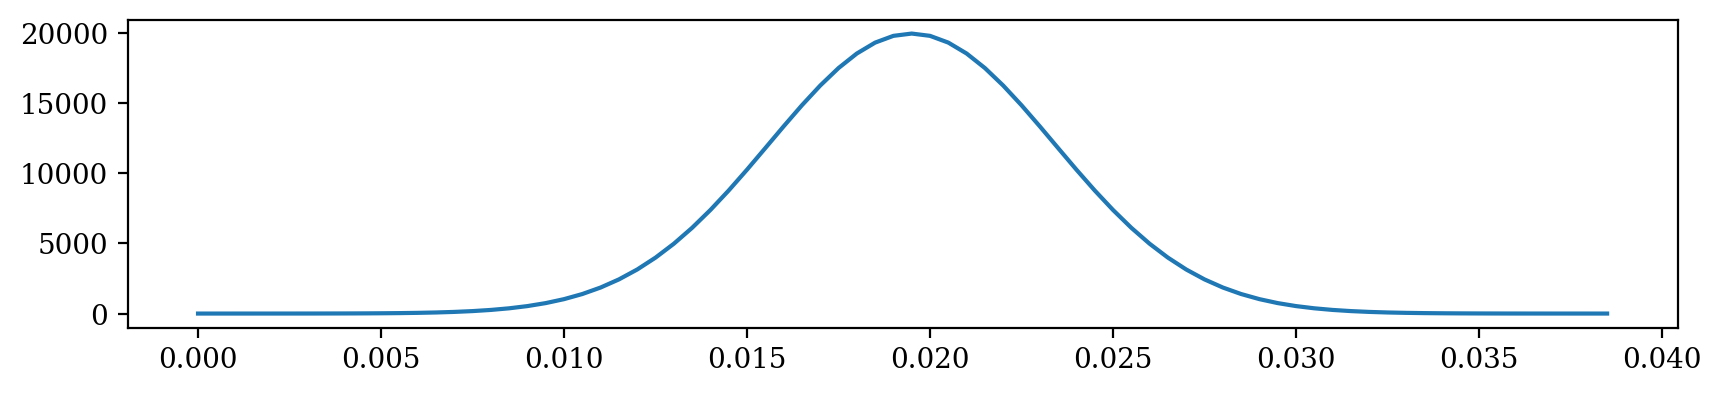

In [28]:
tauPi  = 39*0.0001
tauMid = tauPi*5
tauEnd = tauPi*10

# smooth bragg in time
tbtest = np.arange(0, tauEnd,dt)
# plt.plot(tbtest, V(tbtest))
print(tbtest.size)
plt.figure(figsize=(10,2))
plt.plot(tbtest, VBF(tbtest,tauMid,tauPi))

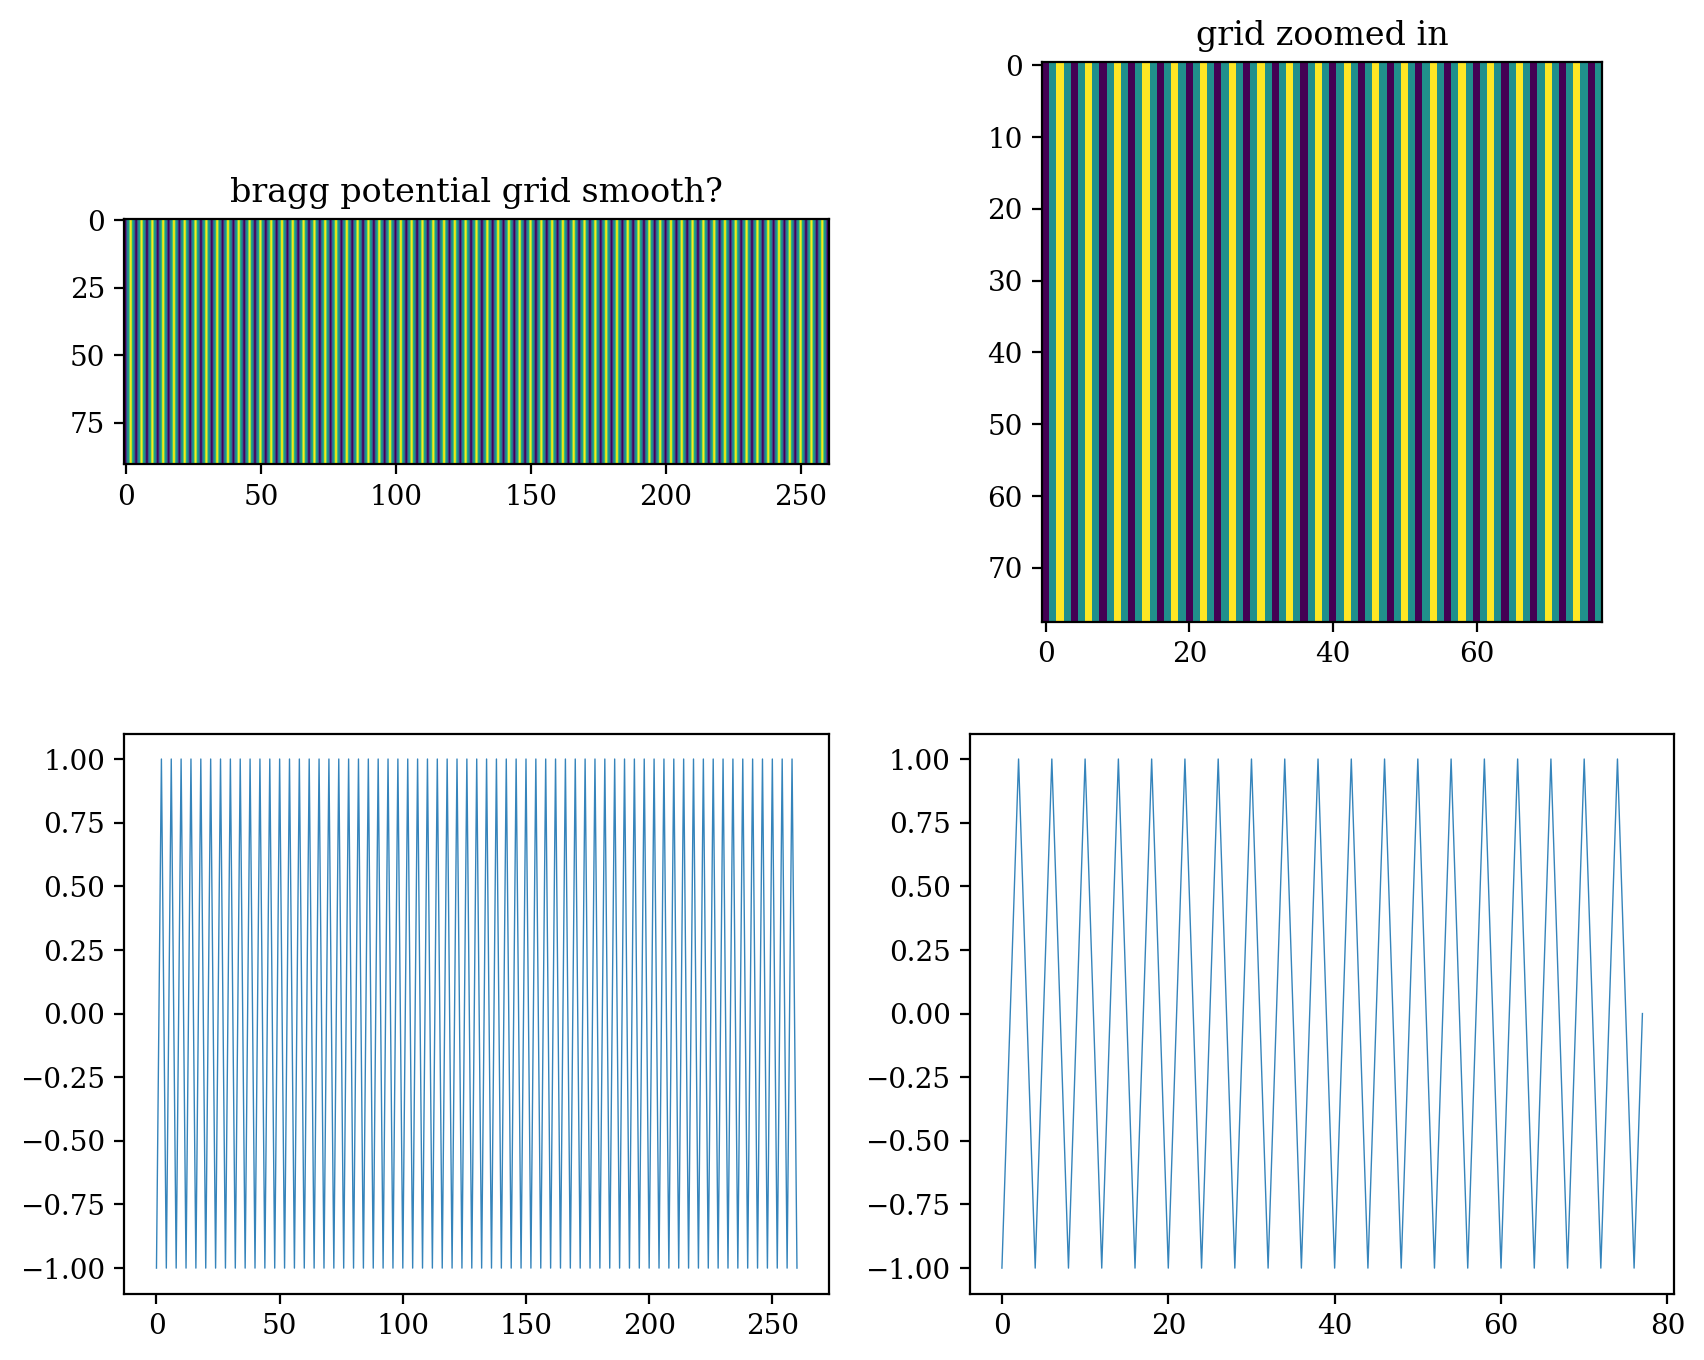

In [29]:
# vtest = np.cos(2*k*xlin)
ncrop = int(0.3*nx)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(cosXGrid.T)
plt.title("bragg potential grid smooth?")

plt.subplot(2,2,2)
plt.imshow(cosXGrid[:ncrop,:ncrop].T)
plt.title("grid zoomed in")

plt.subplot(2,2,3)
plt.plot(cosXGrid[:,0],alpha=0.9,linewidth=0.5)

plt.subplot(2,2,4)
plt.plot(cosXGrid[:ncrop,0],alpha=0.9,linewidth=0.5)

title="bragg_potential_grid"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)

plt.show()
del ncrop
del cosXGrid

## initial wave function

In [33]:
dx

0.2

### Gaussians

In [27]:
sg = 8;
# @njit(parallel=True, fastmath=True)
# @jit('c16[::1](f8[::1],f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,)')
@njit(cache=True)
def psi0gaussianNN(x3, z3, x4, z4, sx3=sg, sz3=sg, sx4=sg, sz4=sg, px3=0.0, pz3=0.0, px4=0.0, pz4=0.0):
    return    np.exp(-0.5*x3**2/sx3**2)\
            * np.exp(-0.5*z3**2/sz3**2)\
            * np.exp(-0.5*x4**2/sx4**2)\
            * np.exp(-0.5*z4**2/sz4**2)\
            * np.exp(+(1j/hb)*(px3*x3 + pz3*z3 + px4*x4 + pz4*z4))

# @njit(parallel=True, fastmath=True)
# @jit('f8(c16[::4],f8,f8)', forceobj=True)
# @jit(forceobj=True)
@njit(cache=True)
def check_norm(psi,dx=dx,dz=dz) -> dtyper:
    return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2))))*(dx*dx*dz*dz)
#     return  np.trapz(
#                 np.trapz(
#                     np.trapz(
#                         np.trapz(np.abs(psi)**2,
#                             dx=dz,axis=numba.literally(3)),
#                         dx=dx,axis=numba.literally(2)),
#                     dx=dz,axis=numba.literally(1))
#                 ,dx=dx,axis=numba.literally(0))
#     with objmode(psi='intp[:]',dx='intp[:]',dz='intp[:]'):
#     return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2,dx=dz,axis=3),dx=dx,axis=2),dx=dz,axis=1),dx=dx,axis=0)
#     out = -1
#     with objmode(out='intp[:]'):
#         out = np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2,dx=dz,axis=3),dx=dx,axis=2),dx=dz,axis=1),dx=dx,axis=0)
#     return out
        
# @njit(parallel=True, fastmath=True)
# @njit(parallel=True)

# @njit(parallel=True)
# def psi0gaussian_loop_helper(sx3,sz3,sx4,sz4,px3,pz3,px4,pz4,xlin,zlin):
#     psi=np.zeros((nx,nz, nx,nz),dtype=dtype)
# #     for (iz3, z3) in enumerate(zlin):
#     for iz3 in prange(nz):
#         z3 = zlin[iz3]
#         for (ix4, x4) in enumerate(xlin):
#             for (iz4, z4) in enumerate(zlin):
#                 psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin, z3, x4, z4,sx3,sz3,sx4,sz4,px3,pz3,px4,pz4)
#     return psi

@njit(parallel=True, cache=True)
# @njit(cache=True)
def psi0gaussian(sx3=sg, sz3=sg, sx4=sg, sz4=sg, px3=0, pz3=0, px4=0, pz4=0, xlin=xlin,zlin=zlin) -> np.ndarray:
#     psi =  psi0gaussian_loop_helper(sx3,sz3,sx4,sz4,px3,pz3,px4,pz4,xlin,zlin)
    psi=np.zeros((nx,nz, nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
    for iz3 in prange(nz):
        z3 = zlin[iz3]
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin, z3, x4, z4,sx3,sz3,sx4,sz4,px3,pz3,px4,pz4)
    normalisation = check_norm(psi)
    return (psi/sqrt(normalisation)).astype(dtype)

# @njit(parallel=True)
@jit(forceobj=True)
# @njit
def only3(psi):
    return np.trapz(np.trapz(np.abs(psi)**2 ,dx=dz,axis=3),dx=dx,axis=2)
#     return np.trapz(np.trapz(np.abs(psi)**2,axis=3),axis=2)*(dx*dz)

# @njit(parallel=True)
@jit(forceobj=True)
def only4(psi):
    return np.trapz(np.trapz(np.abs(psi)**2 ,dx=dx,axis=0),dx=dz,axis=0)



In [28]:
psi0gaussian.signatures

[]

### Opposite Pairs

In [29]:
# @njit(parallel=True)
# def psi0_just_opposite_loop_helper(dx3,dz3,dx4,dz4,s3,s4,px,pz,xlin,zlin):
#     psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
# #     for (iz3, z3) in enumerate(zlin):
#     for iz3 in prange(nz):
#         z3 = zlin[iz3]
#         for (ix4, x4) in enumerate(xlin):
#             for (iz4, z4) in enumerate(zlin):
#                 psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin-dx3,z3-dz3, x4+dx4,z4+dz4, s3,s3, s4,s4,+px,+pz,-px,-pz)
#     return psi


@njit(parallel=True, cache=True)
# @jit(forceobj=True)
# @njit(cache=True)
def psi0_just_opposite(dr=20,s3=sg,s4=sg,pt=0,a=0,xlin=xlin,zlin=zlin):
    dr3 = dr;
    dr4 = (m3/m4) * dr;
    dx3 = dr3 * cos(a)
    dz3 = dr3 * sin(a)
    dx4 = dr4 * cos(a)
    dz4 = dr4 * sin(a)
#     ph = pt;
    px = +pt * cos(a)
    pz = +pt * sin(a)
    
#     print((+px,+pz,-px,-pz))
#     psi = psi0_just_opposite_loop_helper(dx3,dz3,dx4,dz4,s3,s4,px,pz,xlin,zlin)
    psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
    for iz3 in prange(nz):
        z3 = zlin[iz3]
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin-dx3,z3-dz3, x4+dx4,z4+dz4, s3,s3, s4,s4,+px,+pz,-px,-pz)
    normalisation = check_norm(psi)
    return (psi/sqrt(normalisation)).astype(dtype)
    

In [30]:
@njit(cache=True)
def psi0PairNN(x3,z3,x4,z4,dr=20,s3=sg,s4=sg,pt=p,a=0):
    dr3 = dr;
    dr4 = (m3/m4) * dr;
    dx3 = dr3 * cos(a)
    dz3 = dr3 * sin(a)
    dx4 = dr4 * cos(a)
    dz4 = dr4 * sin(a)
#     ph = 0.5 * pt;
    px3 = +pt * cos(a)
    pz3 = +pt * sin(a)
    px4 = -pt * cos(a)
    pz4 = -pt * sin(a)
    return (psi0gaussianNN(x3-dx3,z3-dz3, x4+dx4,z4+dz4, s3,s3, s4,s4,+px3,+pz3,+px4,+pz4) + 
            psi0gaussianNN(x3+dx3,z3+dz3, x4-dx4,z4-dz4, s3,s3, s4,s4,-px3,-pz3,-px4,-pz4)
           )

# @njit(parallel=True)
# def psi0Pair_loop_helper(dr,s3,s4,pt,a,xlin=xlin,zlin=zlin):
#     psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
# #     for (iz3, z3) in enumerate(zlin):
#     for iz3 in prange(nz):
#         z3 = zlin[iz3]
#         for (ix4, x4) in enumerate(xlin):
#             for (iz4, z4) in enumerate(zlin):
#                 psi[:,iz3,ix4,iz4] = psi0PairNN(xlin, z3, x4, z4, dr,s3,s4,pt,a)
#     return psi

@njit(cache=True, parallel=True)
# @njit(cache=True)
def psi0Pair(dr=20,s3=sg,s4=sg,pt=p,a=0,nx=nx,nz=nz):
    psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
    for iz3 in prange(nz):
        z3 = zlin[iz3]
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = psi0PairNN(xlin, z3, x4, z4, dr,s3,s4,pt,a)
    normalisation = check_norm(psi)
    #print(normalisation)
    return (psi/sqrt(normalisation)).astype(dtype)

### Rings

In [31]:
@njit(nogil=True,parallel=True,cache=True) # psi0Pair already parallelised
# @njit(nogil=True,cache=True)
# @njit(cache=True)
def psi0ring_loop_helper(arg_dr,arg_s3,arg_s4,arg_pt,arg_an, 
#                         ):
                         progress_proxy=None):
    psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
    angles_list = np.linspace(0,pi,arg_an+1)[:-1]
#     print(an, psi.shape)
    for ia in range(arg_an):
        a = angles_list[ia]
        # print("working on a = "+str(round(a/pi,4))+" * pi      ",end='\r')
#         print(psi0Pair(dr=dr,s3=s3,s4=s4,pt=pt,a=a).shape)
        psi += (1/arg_an) * psi0Pair(dr=arg_dr,s3=arg_s3,s4=arg_s4,pt=arg_pt,a=a,nx=nx,nz=nz)
#         psi_un = psi0Pair_loop_helper(dr=dr,s3=s3,s4=s4,pt=pt,a=a)
        if progress_proxy != None:
            progress_proxy.update(1)
    return psi.astype(dtype)

# @jit(cache=True,forceobj=True)
def psi0ring_with_logging(arg_dr=20,arg_s3=3,arg_s4=3,arg_pt=p,arg_an=4):   
#     psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
#         for (ix4, x4) in enumerate(xlin):
#             print("working on "+str((iz3,ix4))+"      ",end='\r')
#             for (iz4, z4) in enumerate(zlin):
#                 for a in np.linspace(0,2*pi,360):
#                     psi[:,iz3,ix4,iz4] += psi0PairNN(xlin, z3, x4, z4, dr,s3,s4,pt,a)
#     angles_divs = 4
    angles_list = np.linspace(0,pi,arg_an+1)[:-1]
    
#     if logging:
    print("angles_list = "+ str(np.round(angles_list/pi,4)) + " * pi")
    with ProgressBar(total=arg_an) as progress:
        psi = psi0ring_loop_helper(arg_dr,arg_s3,arg_s4,arg_pt,arg_an,progress)
#     psi = psi0ring_loop_helper(dr,s3,s4,pt,an)
    normalisation = check_norm(psi)
#     print(" ")
#     print("normalisation =", normalisation)
    return (psi/sqrt(normalisation)).astype(dtype)
#     else:
# #         for a in angles_list:
# #             psi += (1/an) * psi0Pair(dr=dr,s3=s3,s4=s4,pt=p,a=a)
#         psi = psi0ring_loop_helper(dr,s3,s4,pt,an,None)
#         normalisation = check_norm(psi)
#         return psi/sqrt(normalisation)
    
# @njit(cache=True)
def psi0ring(arg_dr=20,arg_s3=3,arg_s4=3,arg_pt=p,arg_an=4):   
    psi = psi0ring_loop_helper(arg_dr,arg_s3,arg_s4,arg_pt,arg_an)
    normalisation = check_norm(psi)
    return (psi/sqrt(normalisation)).astype(dtype)

In [34]:
gc.collect()

12923

### Testings

#### Testings

In [ ]:
su = 4
psi = psi0gaussian(sx3=su, sz3=su, sx4=su, sz4=su, px3=-100, pz3=-50, px4=100, pz4=50)
t = 0

tempTest3 = only3(psi)
tempTest4 = only4(psi)
print("check normalisation psi", check_norm(psi))
phi, swnf = phiAndSWNF(psi)
tempTest3phi = only3phi(phi)
tempTest4phi = only4phi(phi)
print("check normalisation phi", check_norm_phi(phi))
print("swnf =", swnf)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.imshow(np.flipud(tempTest3.T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,2)
plt.imshow(np.flipud(tempTest4.T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,3)
plt.imshow((tempTest3phi.T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.subplot(2,2,4)
plt.imshow((tempTest4phi.T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.show()
del tempTest3, tempTest4, tempTest3phi, tempTest4phi
current_py_memory_print()

In [ ]:
tempTest3phi = only3phi(phi)

#### Testings v2

In [39]:
print(22*32/60, "min")

11.733333333333333 min


In [ ]:
# su = 4
# psi = psi0Pair(dx=20,s3=su,s4=su,pt=0,a=0)
# del psi
psi = psi0ring_with_logging(dr=5,s3=1.7,s4=1.7,pt=2*hb*k,an=32)
t = 0

check normalisation psi 1.0000000000000002
check normalisation phi 0.9999999999999998
swnf = (192.47056959528948+0j)


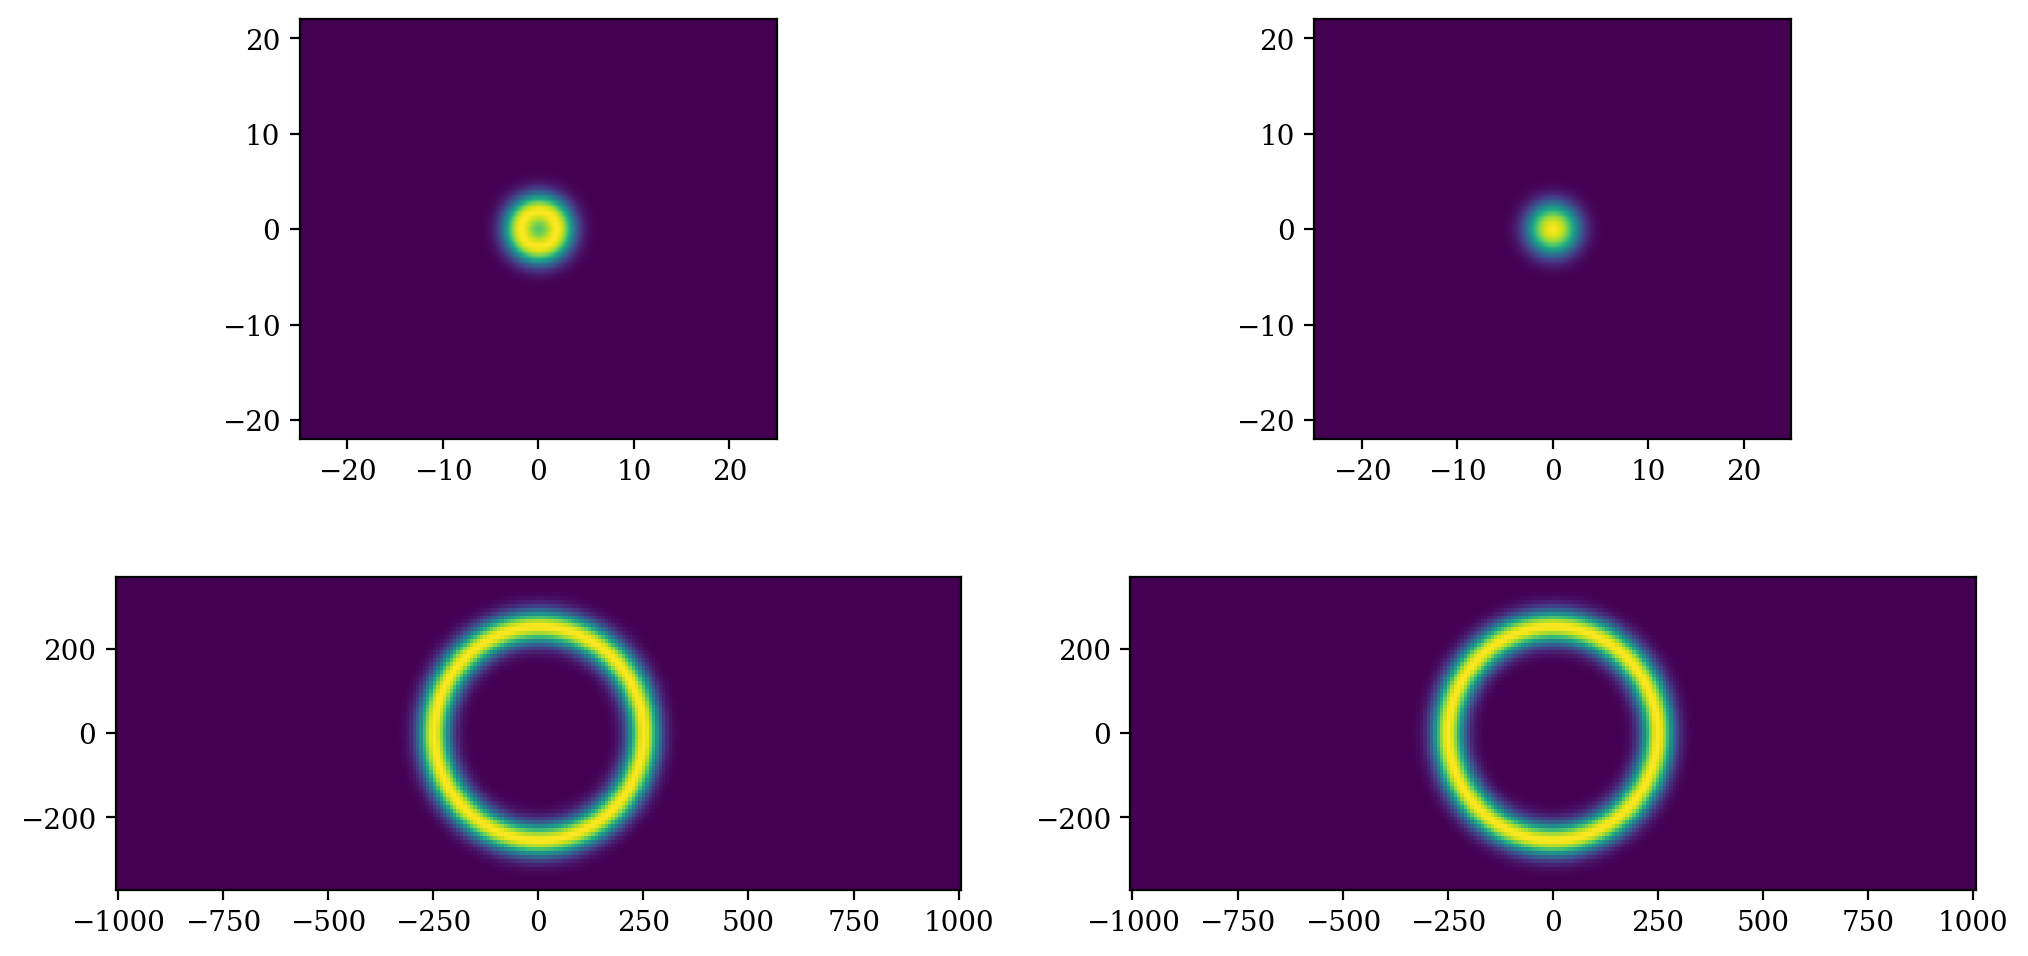

13638.975MB of system memory used


In [56]:
print("check normalisation psi", check_norm(psi))
phi, swnf = phiAndSWNF(psi)
print("check normalisation phi", check_norm_phi(phi))
print("swnf =", swnf)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.imshow(np.flipud(only3(psi).T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,2)
plt.imshow(np.flipud(only4(psi).T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,3)
plt.imshow(np.flipud(only3phi(phi).T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(np.flipud(only4phi(phi).T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.show()
current_py_memory_print()

Notes on parameters

`psi = psi0ring(dr=40,s3=2,s4=2,pt=p,an=32,logging=True)` took fucking 15 minutes to generate but it looks pretty smooth

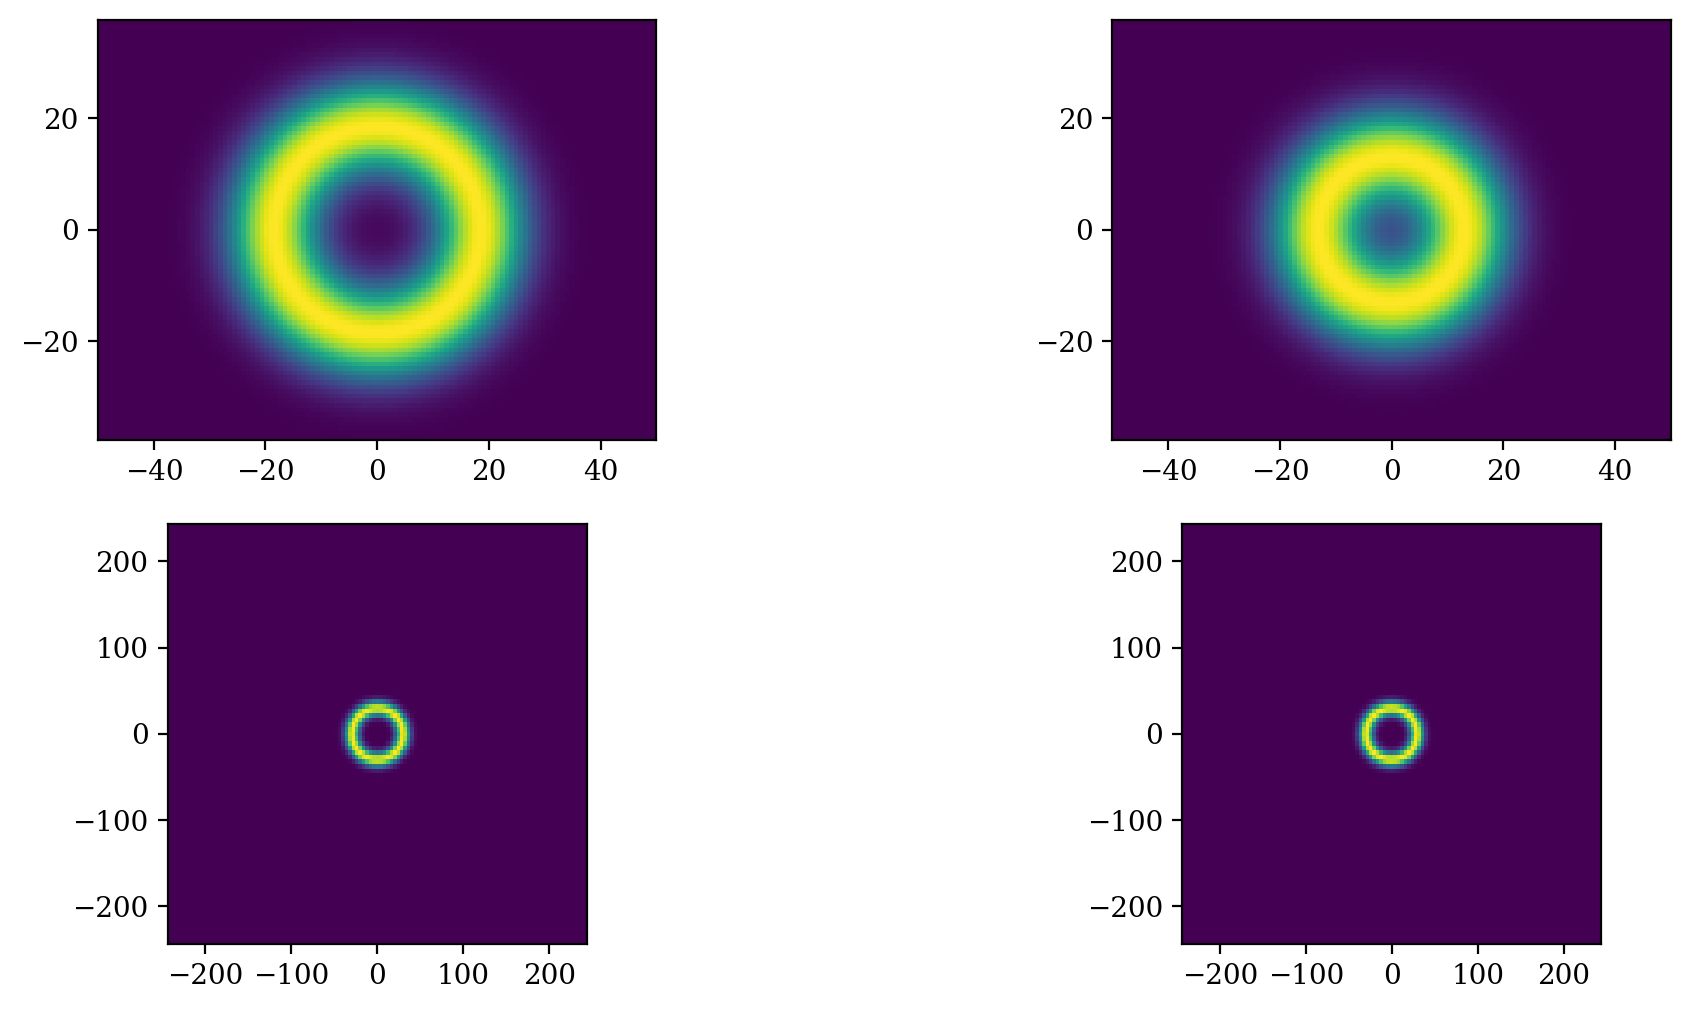

`psi = psi0ring_with_logging(dr=40,s3=3,s4=3,pt=2*hb*k,an=32)`
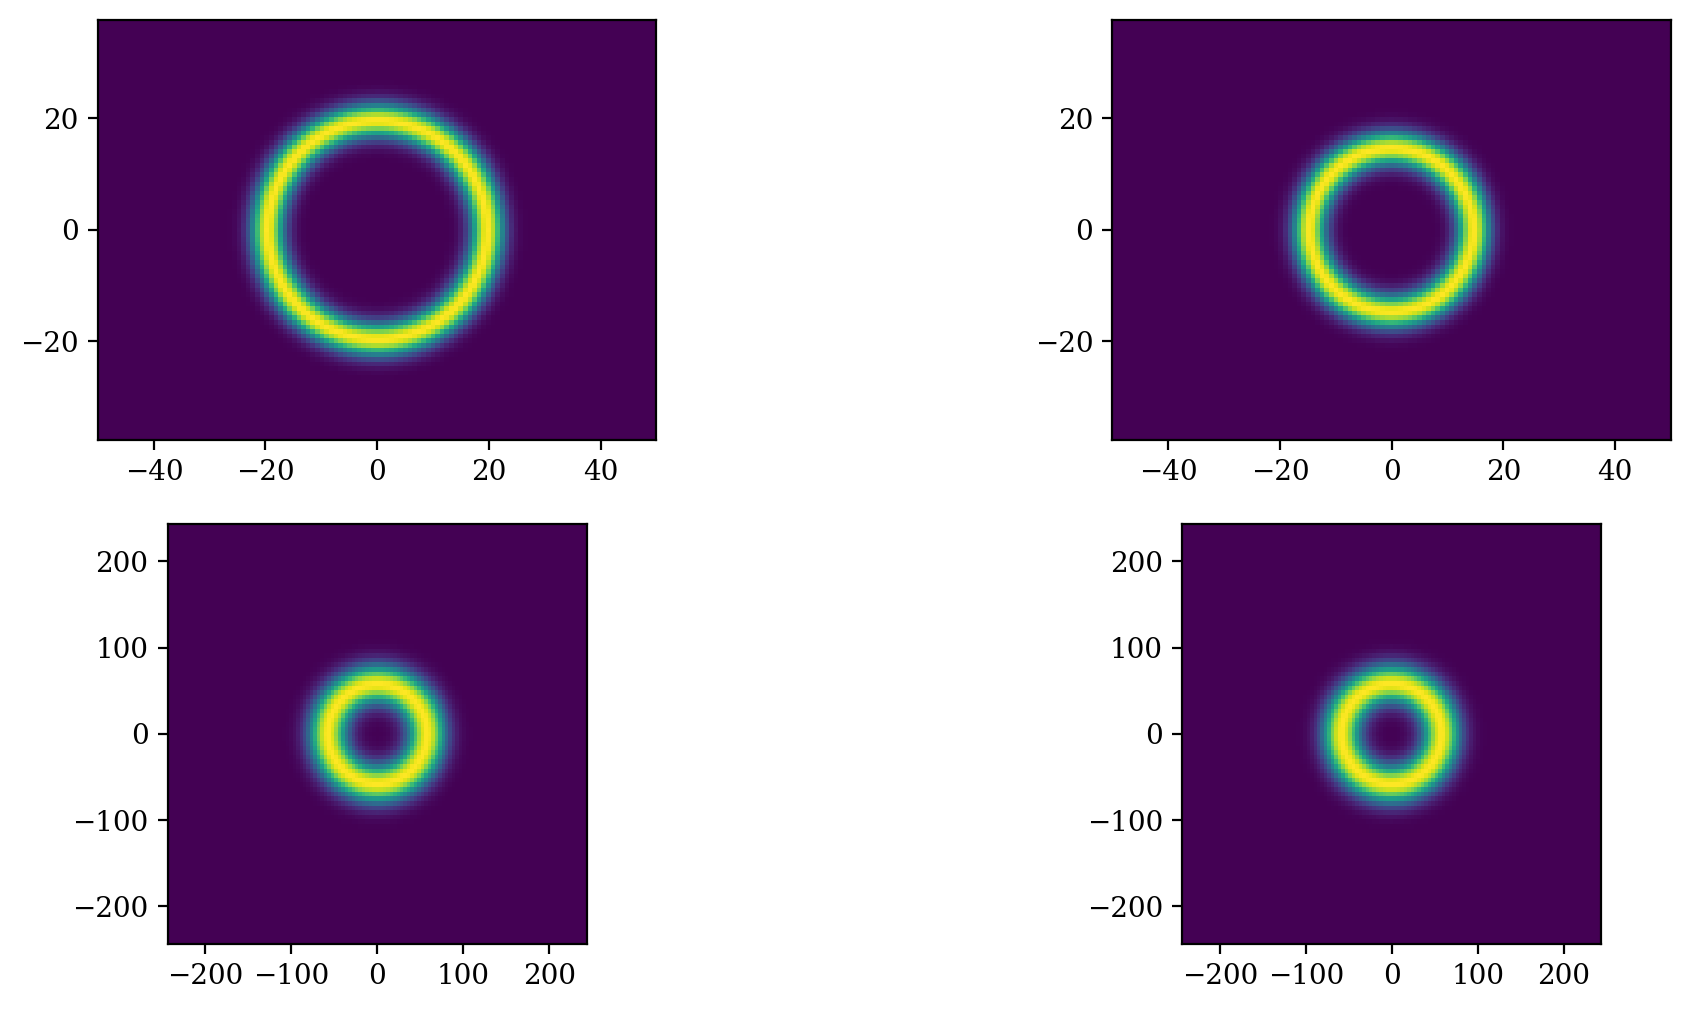

In [106]:
((nx-1)/2, (nz-1)/2)

(60.0, 45.0)

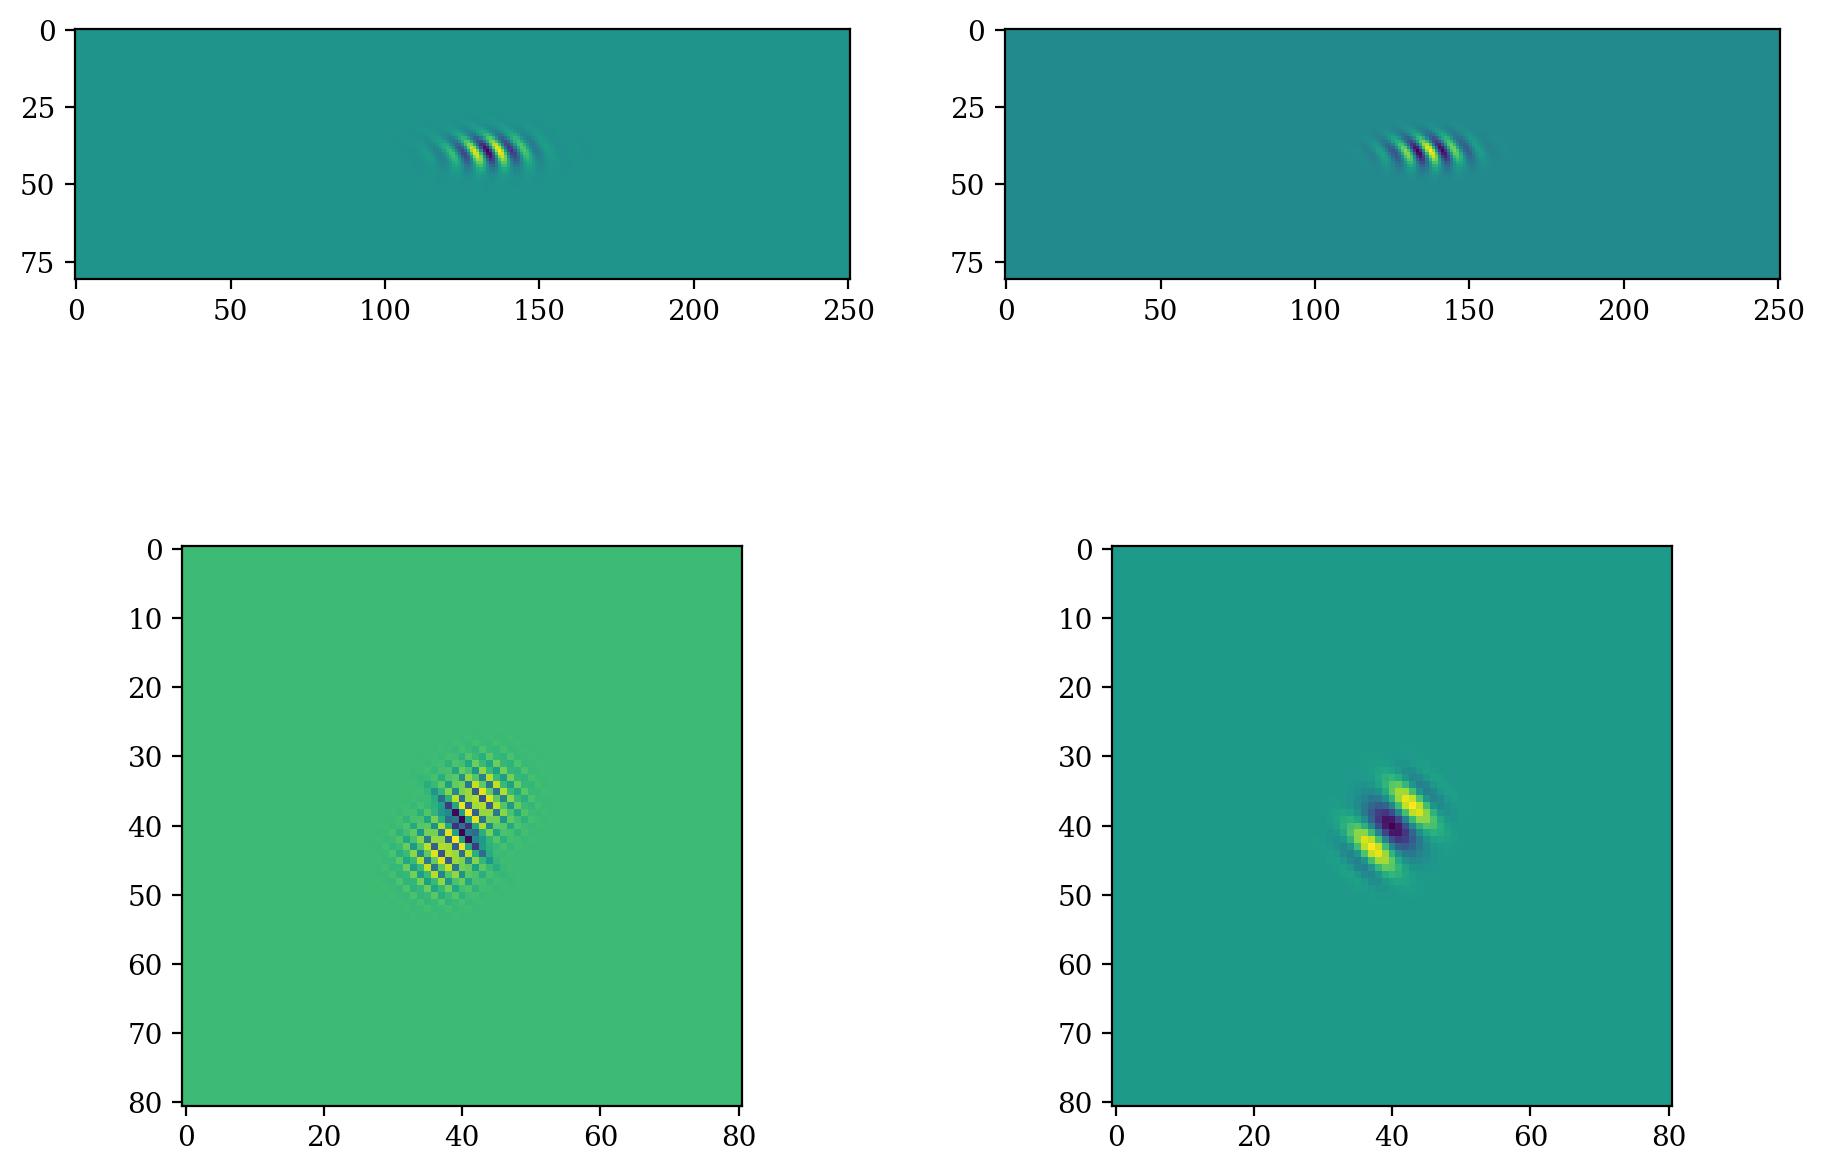

In [57]:
plt.figure(figsize=(11,8))
plt.subplot(2,2,1)
plt.imshow(np.real(psi[60,:,:,45]))
plt.subplot(2,2,2)
plt.imshow(np.real(psi[:,45,60,:].T))
plt.subplot(2,2,3)
plt.imshow(np.real(psi[60,:,60,:]))
plt.subplot(2,2,4)
plt.imshow(np.real(psi[30,:,90,:]))

no idea what those mean...

## Correlation Function

In [32]:
def gx3x4_calc(psi,cut=5.0):
    ind = abs(zlin) < (cut+1e-15)*dz
    gx3x4 = np.trapz(np.abs(psi[:,:,:,ind])**2,zlin[ind],axis=3)
    gx3x4 = np.trapz(gx3x4[:,ind,:],zlin[ind],axis=1)
    return gx3x4

In [33]:
def plot_gx3x4(gx3x4,cut):
    xip = xlin > 0
    xim = xlin < 0
    gpp = np.trapz(np.trapz(gx3x4[:,xip],xlin[xip],axis=1)[xip],xlin[xip],axis=0)
    gpm = np.trapz(np.trapz(gx3x4[:,xim],xlin[xim],axis=1)[xip],xlin[xip],axis=0)
    gmp = np.trapz(np.trapz(gx3x4[:,xip],xlin[xip],axis=1)[xim],xlin[xim],axis=0)
    gmm = np.trapz(np.trapz(gx3x4[:,xim],xlin[xim],axis=1)[xim],xlin[xim],axis=0)
    E = (gpp+gmm-gpm-gmp)/((gpp+gmm+gpm+gmp))
    
    plt.imshow(np.flipud(gx3x4.T),extent=[-xmax,xmax,-xmax,xmax])
    plt.title("$g^{(2)}_{\pm\pm}$ of $z_\mathrm{cut} = "+str(cut)+"dz$ and $E="+str(round(E,4))+"$")
    plt.xlabel("$x_3$")
    plt.ylabel("$x_4$")
    plt.axhline(y=0,color='white',alpha=0.8,linewidth=0.7)
    plt.axvline(x=0,color='white',alpha=0.8,linewidth=0.7)
    plt.text(+xmax*0.6,+xmax*0.8,"$g^{(2)}_{++}="+str(round(gpp,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(-xmax*0.6,+xmax*0.8,"$g^{(2)}_{-+}="+str(round(gmp,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(+xmax*0.6,-xmax*0.8,"$g^{(2)}_{+-}="+str(round(gpm,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(-xmax*0.6,-xmax*0.8,"$g^{(2)}_{--}="+str(round(gmm,4))+"$", color='white',ha='center',alpha=0.9)
    

In [34]:
def plot_gx3x4_phi(gx3x4,cut):
    xip = pxlin > 0
    xim = pxlin < 0
    gpp = np.trapz(np.trapz(gx3x4[:,xip],pxlin[xip],axis=1)[xip],pxlin[xip],axis=0)
    gpm = np.trapz(np.trapz(gx3x4[:,xim],pxlin[xim],axis=1)[xip],pxlin[xip],axis=0)
    gmp = np.trapz(np.trapz(gx3x4[:,xip],pxlin[xip],axis=1)[xim],pxlin[xim],axis=0)
    gmm = np.trapz(np.trapz(gx3x4[:,xim],pxlin[xim],axis=1)[xim],pxlin[xim],axis=0)
    E = (gpp+gmm-gpm-gmp)/((gpp+gmm+gpm+gmp))
    
    plt.imshow(np.flipud(gx3x4.T),extent=np.array([-pxmax,pxmax,-pxmax,pxmax])/(hb*k))
    plt.title("$g^{(2)}_{\pm\pm}$ of $z_\mathrm{cut} = "+str(cut)+"dz$ and $E="+str(round(E,4))+"$")
    plt.xlabel("$px_3$")
    plt.ylabel("$px_4$")
    plt.axhline(y=0,color='white',alpha=0.8,linewidth=0.7)
    plt.axvline(x=0,color='white',alpha=0.8,linewidth=0.7)
    xtext = pxmax/(hb*k)
    plt.text(+xtext*0.6,+xtext*0.8,"$g^{(2)}_{++}="+str(round(gpp,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(-xtext*0.6,+xtext*0.8,"$g^{(2)}_{-+}="+str(round(gmp,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(+xtext*0.6,-xtext*0.8,"$g^{(2)}_{+-}="+str(round(gpm,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(-xtext*0.6,-xtext*0.8,"$g^{(2)}_{--}="+str(round(gmm,4))+"$", color='white',ha='center',alpha=0.9)
    

### Plotting Correlations

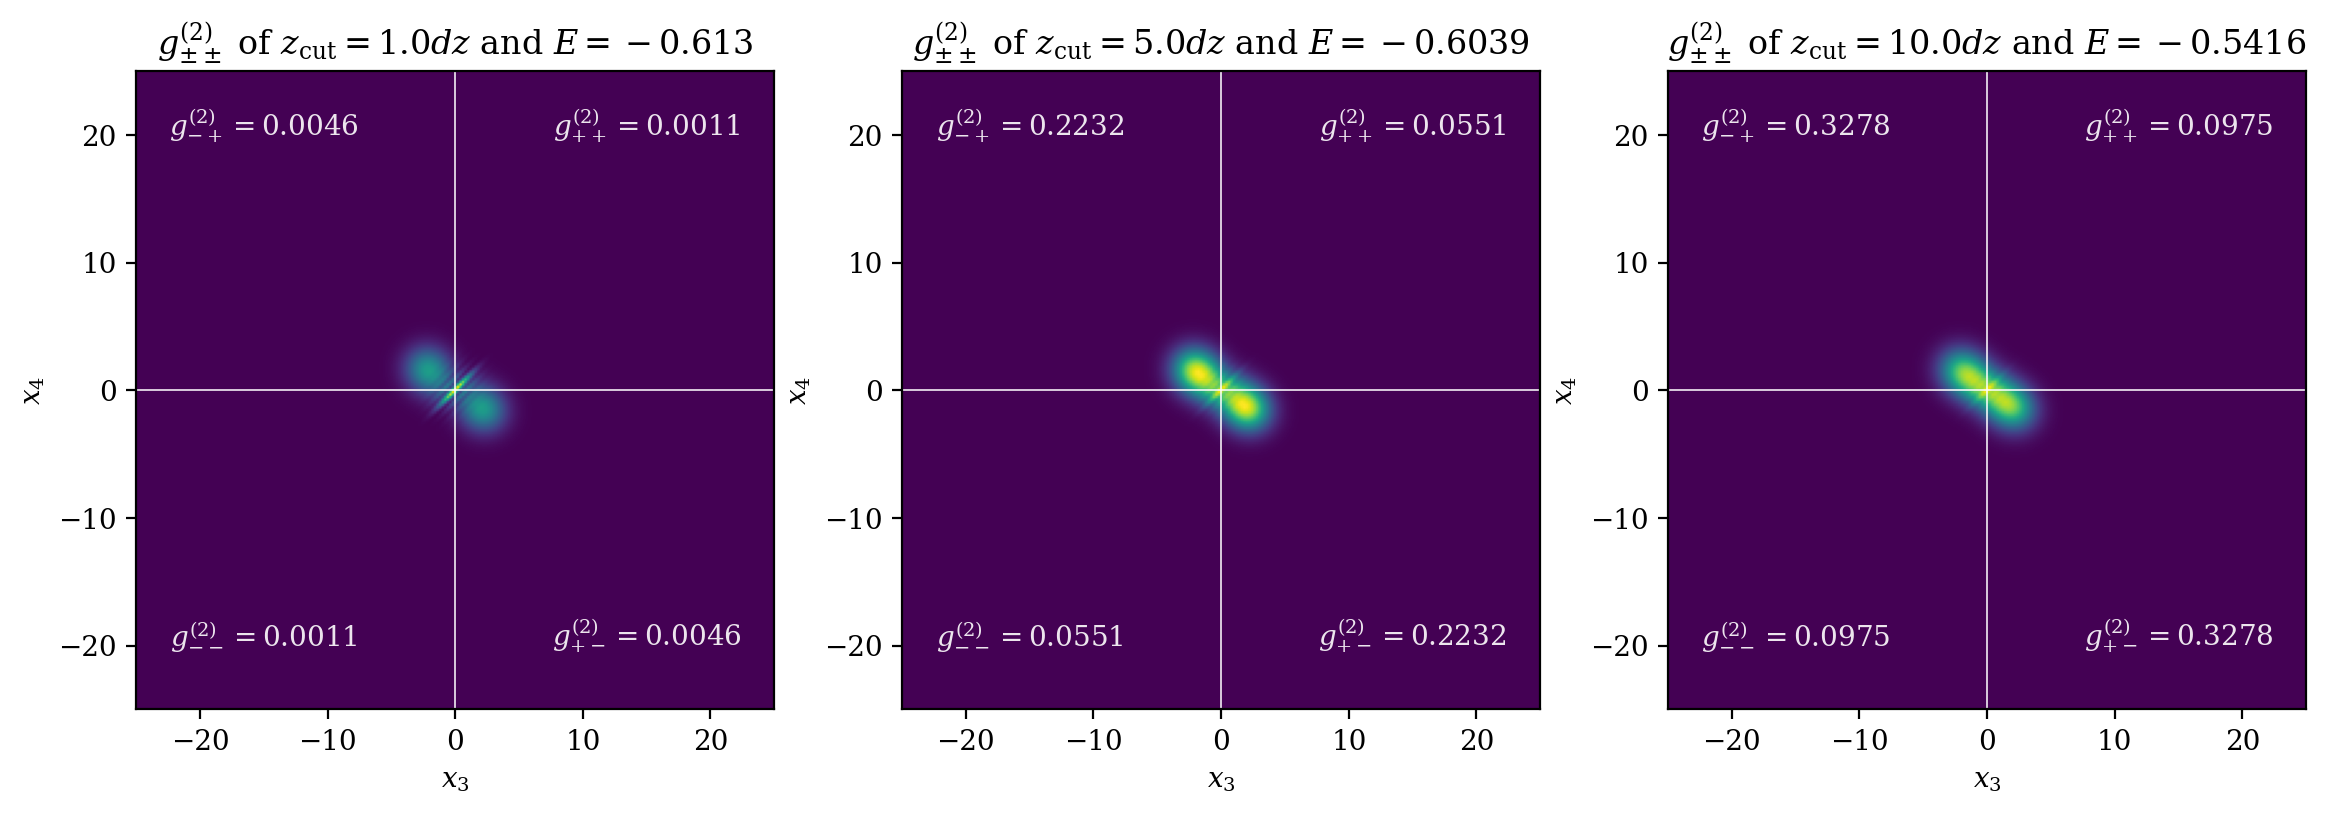

In [67]:
plt.figure(figsize=(14,6))

cut_list = [1.0, 5.0, 10.0]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(psi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4(gx3x4,cut)
plt.show()

 eq on p.73 GoodNotes document
 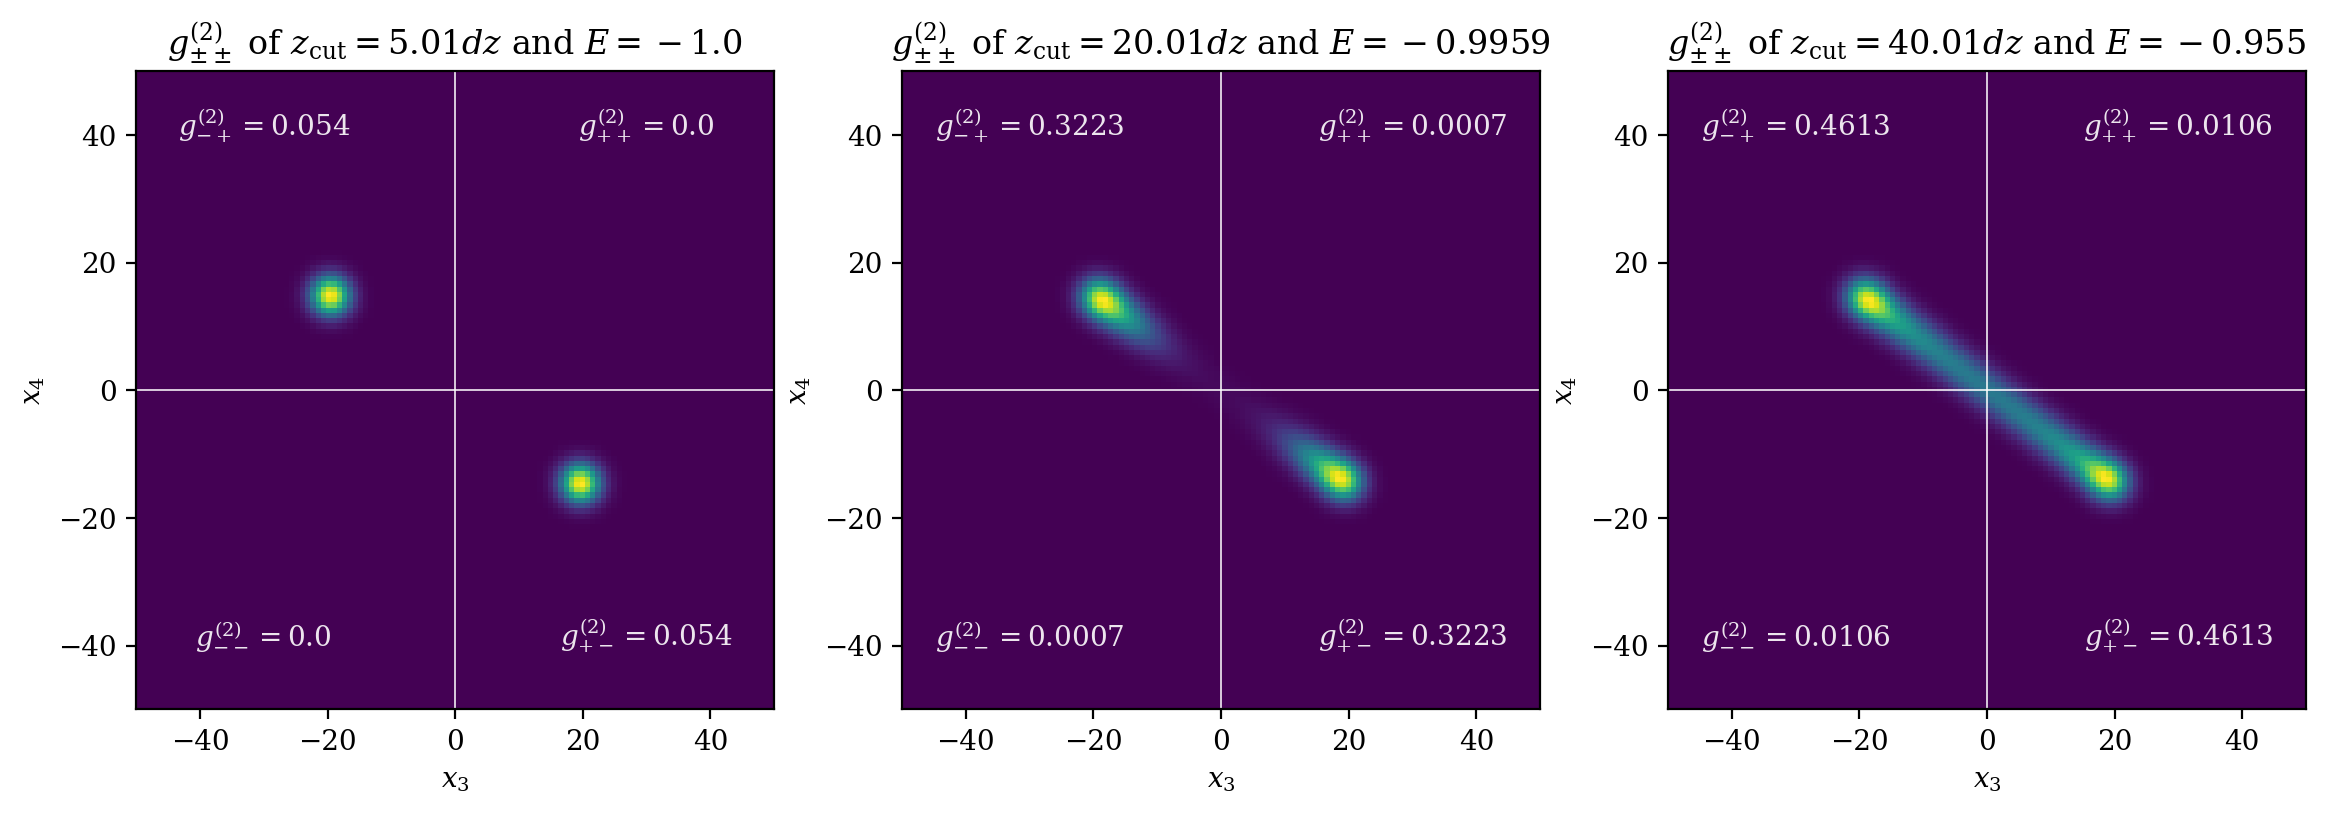

In [61]:
del gx3x4

## FFT to momentum

In [35]:
@jit(forceobj=True, cache=True)
def only3phi(phi):
    return np.trapz(np.trapz(np.abs(phi)**2,dx=dpz,axis=3),dx=dpx,axis=2)
#     return np.trapz(np.trapz(np.abs(phi)**2,dx=dpx,axis=2),dx=dpz,axis=2)
@jit(forceobj=True, cache=True)
def only4phi(phi):
    return np.trapz(np.trapz(np.abs(phi)**2,dx=dpx,axis=0),dx=dpz,axis=0)

@njit(cache=True)
def check_norm_phi(phi):
#     return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(phi)**2,dx=dpz,axis=3),dx=dpx,axis=2),dx=dpz,axis=1),dx=dpx,axis=0)
    return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(phi)**2))))*(dpx*dpx*dpz*dpz)



In [36]:
@jit(forceobj=True, cache=True)
def phiAndSWNF(psi, nthreads=nthreads):
    phiUN = np.flip(np.flip(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fftn(psi,threads=nthreads,norm='ortho')),axis=1),axis=3)
    superWeirdNormalisationFactorSq = check_norm_phi(phiUN)
    swnf = sqrt(superWeirdNormalisationFactorSq)
    phi = phiUN/swnf
    return phi, (swnf+0*1j)

@jit(forceobj=True, cache=True)
def toPhi(psi, swnf, nthreads=nthreads) -> np.ndarray:
    return np.flip(np.flip(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fftn(psi,threads=nthreads,norm='ortho')),axis=1),axis=3)/swnf

@jit(forceobj=True, cache=True)
def toPsi(phi, swnf, nthreads=nthreads) -> np.ndarray:
    return pyfftw.interfaces.numpy_fft.ifftn(np.fft.ifftshift(np.flip(np.flip(phi*swnf,axis=3),axis=1)),threads=nthreads,norm='ortho')




In [40]:
# # @njit(parallel=True,cache=True)
# @jit
# def phiAndSWNF(psi):
#     phiUN = np.flip(np.flip(np.fft.fftshift(np.fft.fftn(psi,norm='ortho')),axis=1),axis=3)
#     superWeirdNormalisationFactorSq = check_norm_phi(phiUN)
#     swnf = sqrt(superWeirdNormalisationFactorSq)
#     phi = phiUN/swnf
#     return phi, swnf

# @njit(parallel=True,cache=True)
# def toPhi(psi, swnf):
#     return np.flip(np.flip(np.fft.fftshift(np.fft.fftn(psi,norm='ortho')),axis=1),axis=3)/swnf

# @njit(parallel=True,cache=True)
# def toPsi(phi, swnf):
#     return np.fft.ifftn(np.fft.ifftshift(np.fliplr(phi*swnf)),norm='ortho')

In [47]:
del t, psi, phi, swnf

NameError: name 't' is not defined

## Scattering via contact potential ?

In [46]:
3*hb*k/m3

249.39454740706233

In [47]:
20/249/dt

160.6425702811245

In [47]:
# del psi_test

In [45]:
-(1j/hb) * strength34 * np.exp(-((0-0)**2 +(0-0)**2)/(4*a34**2)) *0.5*dt

-0.3936524332444204j

In [37]:
# a34 = 0.029 #µm
a34 = 0.5 #µm
strength34 = 1e5 # I don't know

numba.set_num_threads(7)
# Each thread will roughtly multiply the memory usage!
# e.g. single thread 20GB -> 2 threads ~30GB

@njit(parallel=True,cache=True)
# @njit
def scattering_evolve_loop_helper2_inner_psi_step(psi_init):
    psi = psi_init
    for iz3 in prange(nz):
        z3 = zlin[iz3]
#     for (iz3, z3) in enumerate(zlin):
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] *= np.exp(-(1j/hb) * # this one is unitary time evolution operator
                                        strength34 *
                                        np.exp(-((xlin-x4)**2 +(z3-z4)**2)/(4*a34**2))
                                               # inside the guassian contact potential
                                               *0.5*dt
                                            )
    return psi

@njit(parallel=True,cache=True)
# @njit
def scattering_evolve_loop_helper2_inner_phi_step(phi_init):
    phi = phi_init
    for iz3 in prange(nz):
        pz3 = pzlin[iz3]
#     for (iz3, pz3) in enumerate(pzlin):
        for (ix4, px4) in enumerate(pxlin):
            for (iz4, pz4) in enumerate(pzlin):
                phi[:,iz3,ix4,iz4] *= np.exp(-(1j/hb) * (0.5/m3) * (dt) * (pxlin**2 + pz3**2) \
                                               -(1j/hb) * (0.5/m4) * (dt) * (  px4**2 + pz4**2))
    return phi

# @jit(nogil=True, parallel=True, forceobj=True)
@jit(nogil=True, forceobj=True)
# @njit(nogil=True, parallel=True)
def scattering_evolve_loop_helper2(t_init, psi_init, swnf, steps=20, progress_proxy=None):
    t = t_init
    psi = psi_init
    for ia in prange(steps):
        
        psi = scattering_evolve_loop_helper2_inner_psi_step(psi)
#         phi = np.zeros_like(psi, dtype=dtype)
#         with objmode(phi='complex128[:,:,:,:]'):
        phi = toPhi(psi, swnf, nthreads=7)
        phi = scattering_evolve_loop_helper2_inner_phi_step(phi)
        #del psi 
        # might cause memory issues
#         psi2 = np.zeros_like(phi, dtype=dtype)
#         with objmode(psi2='complex128[:,:,:,:]'):
        psi = toPsi(phi, swnf, nthreads=7)
#         psi = psi2
        psi = scattering_evolve_loop_helper2_inner_psi_step(psi)
        t += dt 
        if progress_proxy != None:
            progress_proxy.update(1)                                   
    return (t, psi, phi)

In [38]:
def scattering_evolve_loop_plot(t,f,psi,phi, 
                                plt_show=True, plt_save=False, 
                                plt_save_func_name="scattering_evolve_loop_plot"):
    t_str = f"{t:.5f}"
    if plt_show:
        print("t = " +t_str+ " \t\t frame =", f, "\t\t memory used: " + 
              str(round(current_py_memory()/1000**2,3)) + "MB  ")

    fig = plt.figure(figsize=(12,7))
    plt.subplot(2,2,1)
    plt.imshow(np.flipud(only3(psi).T), extent=[-xmax,xmax,-zmax, zmax])
    plt.xlabel("$x \ (\mu m)$")
    plt.ylabel("$z \ (\mu m)$")
    plt.title("$t="+t_str+" \ ms $")

    plt.subplot(2,2,2)
    plt.imshow(np.flipud(only4(psi).T), extent=[-xmax,xmax,-zmax, zmax])
    plt.xlabel("$x \ (\mu m)$")
    plt.ylabel("$z \ (\mu m)$")

    plt.subplot(2,2,3)
    plt.imshow((only3phi(phi).T), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k))
    # plt.colorbar()
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.ylabel("$p_z \ (\hbar k)$")

    plt.subplot(2,2,4)
    plt.imshow((only4phi(phi).T), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k))
    # plt.colorbar()
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.xlabel("$p_x \ (\hbar k)$")

    if plt_save:
        title= output_prefix_bracket + " "+plt_save_func_name+" (f="+str(f)+",t="+t_str+")" 
        plt.savefig("output/"+title+".pdf", dpi=600)
        plt.savefig("output/"+title+".png", dpi=600)
    
    if plt_show: plt.show() 
    else:        plt.close(fig) 

In [39]:
gc.collect()
su = 1.7
se = 5
print("want to stop at t =", (0.5*se+5)/v3)
print("number of steps is ", (0.5*se+5)/v3/dt)

print_every = 2
frames_count = 90
total_steps = print_every * frames_count
print("Total steps =" ,total_steps)
print("t_final =", total_steps*dt)

want to stop at t = 0.09021849207984266
number of steps is  180.43698415968532
Total steps = 180
t_final = 0.09


In [41]:
assert False, "catch auto run"

AssertionError: catch auto run

In [56]:
psi = psi0_just_opposite(dr=se,s3=su,s4=su,pt=-2*hb*k,a=0.5*pi)
t = 0
f = 0
phi, swnf = phiAndSWNF(psi, nthreads=7)

tested on A2485
```
%timeit _ = phiAndSWNF(psi,nthreads=1)
28.2 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=2)
21.1 s ± 352 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=3)
18.8 s ± 827 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=4)
17.2 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=5)
16.6 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=6)
12.9 s ± 1.51 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=7)
11.9 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=8)
11.8 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

```

In [59]:
scattering_evolve_loop_plot(t,f,psi,phi, plt_show=False, plt_save=False)

In [ ]:
with ProgressBar(total=total_steps) as progressbar:
    for f in range(frames_count):
        scattering_evolve_loop_plot(t,f,psi,phi, plt_show=True, plt_save=True)
        gc.collect()
        (t,psi,phi) = scattering_evolve_loop_helper2(t,psi,swnf,steps=print_every,progress_proxy=progressbar)
scattering_evolve_loop_plot(t,f+1,psi,phi, plt_show=True, plt_save=True)

In [47]:
import glob
import contextlib
import PIL

In [52]:
# https://stackoverflow.com/a/57751793/8798606
# filepaths
fp_in  = "/Users/tonyyan/Documents/_ANU/_Mass-Entanglement/bell correlations/simulations/output/(20230211-114917-F) scattering/*.png"
fp_out = "/Users/tonyyan/Documents/_ANU/_Mass-Entanglement/bell correlations/simulations/output/(20230211-114917-F) scattering/animated.gif"


In [90]:
# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(PIL.Image.open(f)) for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=50, loop=0)

In [ ]:
with ProgressBar(total=total_steps) as progressbar:
    for f in range(frames_count):
        scattering_evolve_loop_plot()
        (t,psi,phi) = scattering_evolve_loop_helper(t,psi,swnf,steps=print_every,progress_proxy=progressbar)
scattering_evolve_loop_plot()

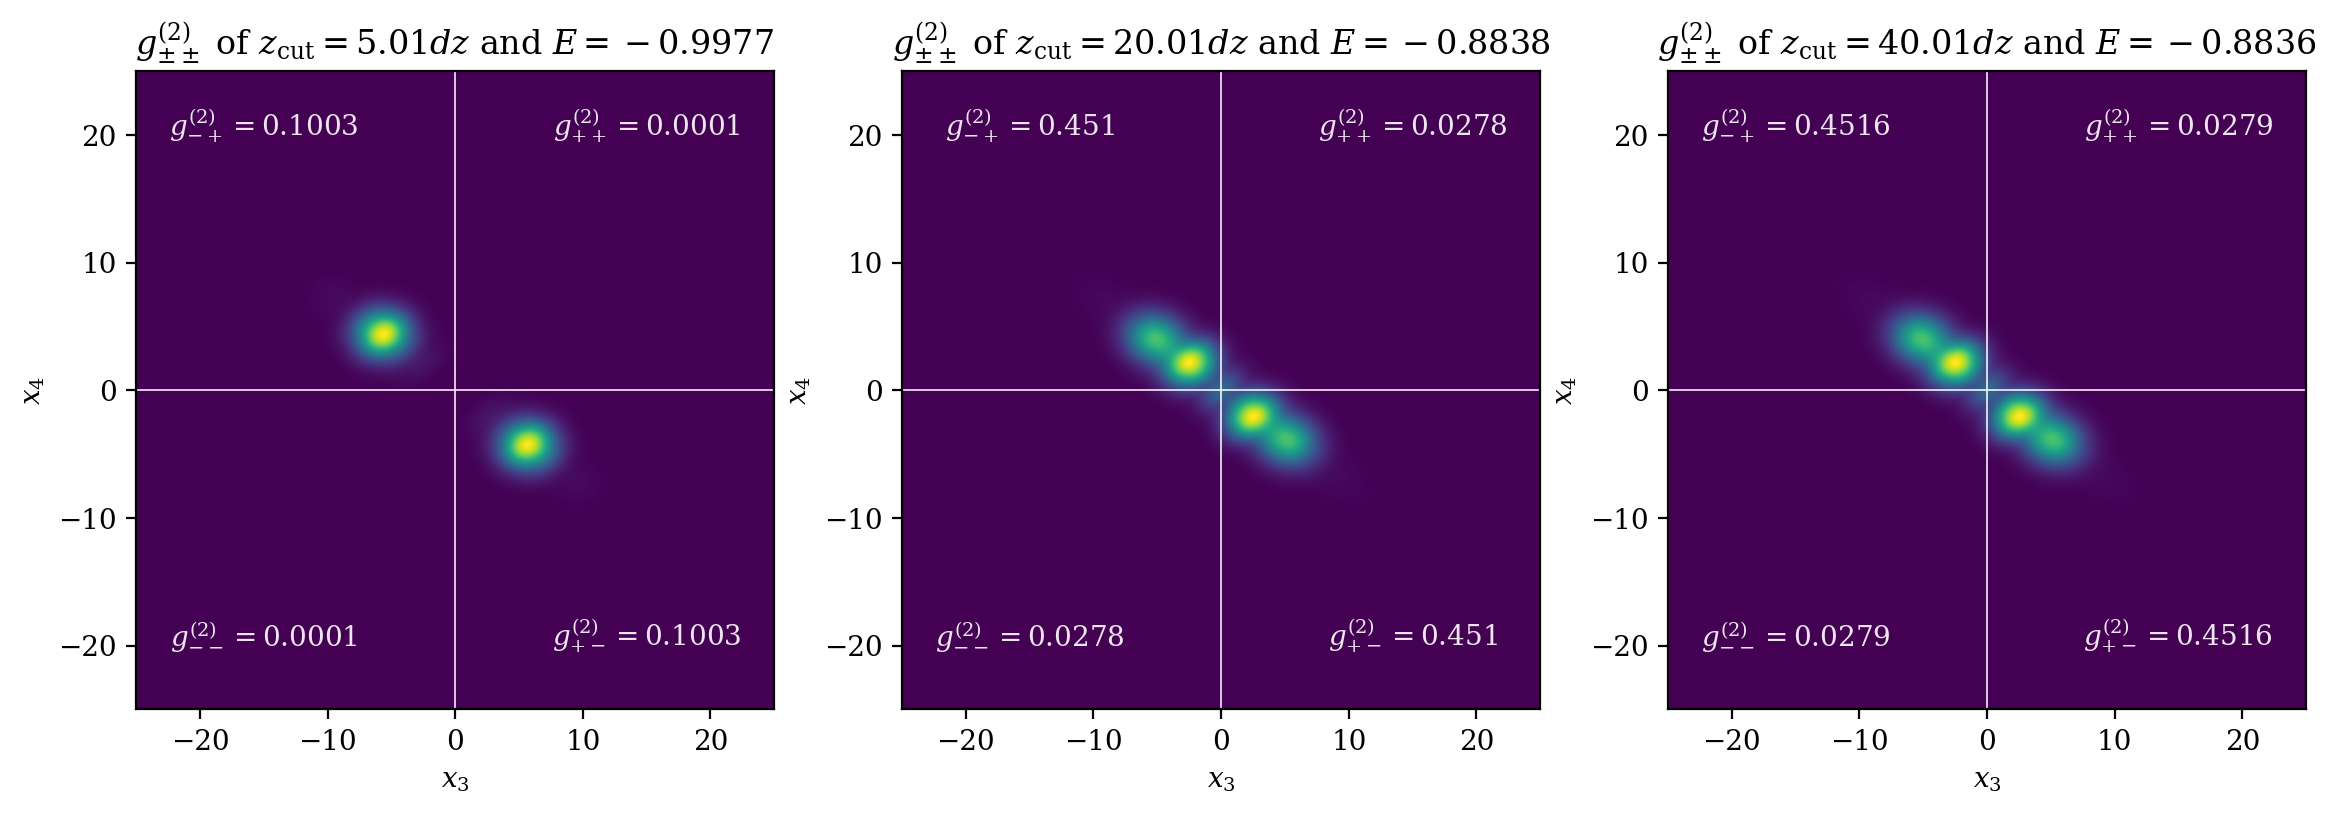

In [91]:
plt.figure(figsize=(14,6))

cut_list = [5.01, 20.01, 40.01]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(psi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4(gx3x4,cut)
plt.show()


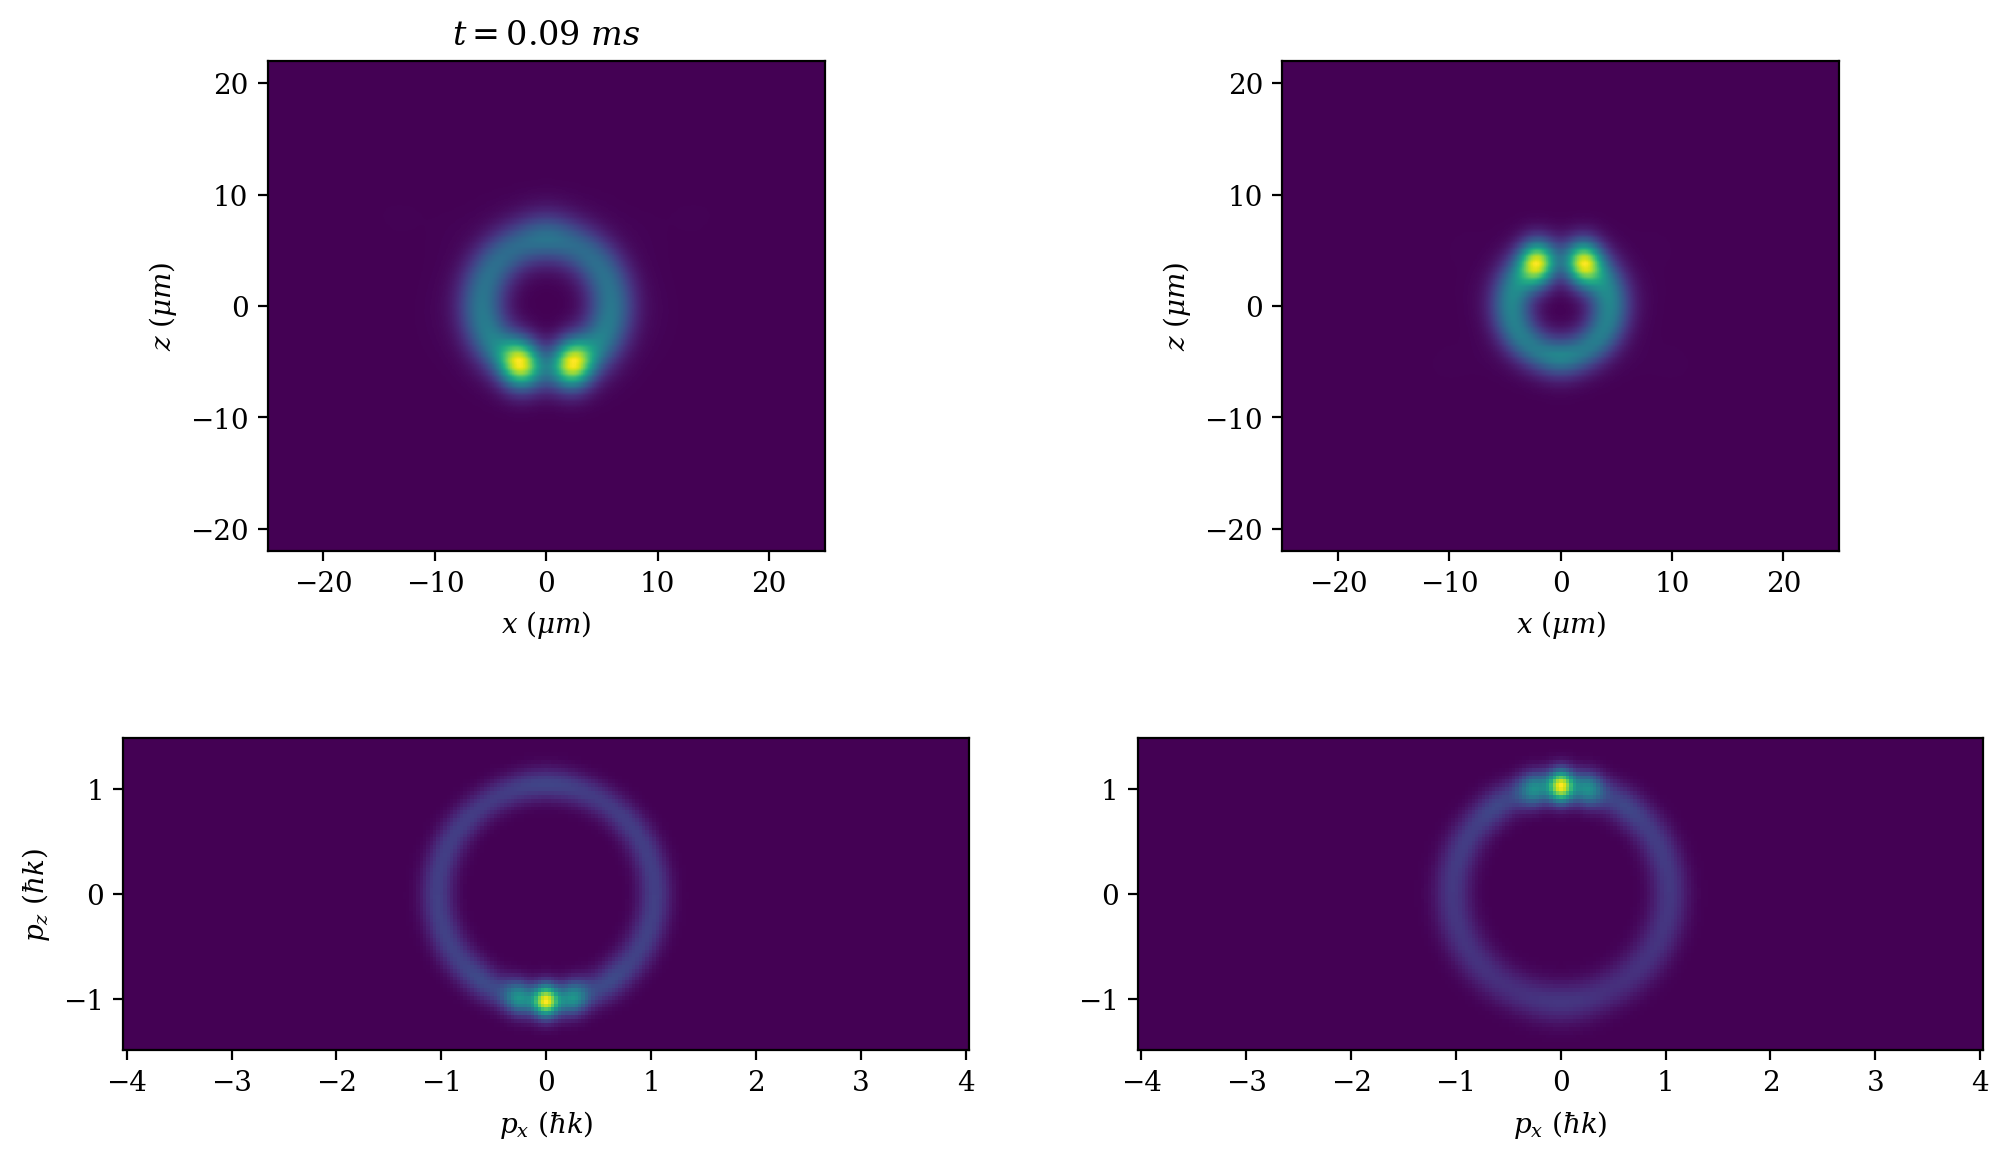

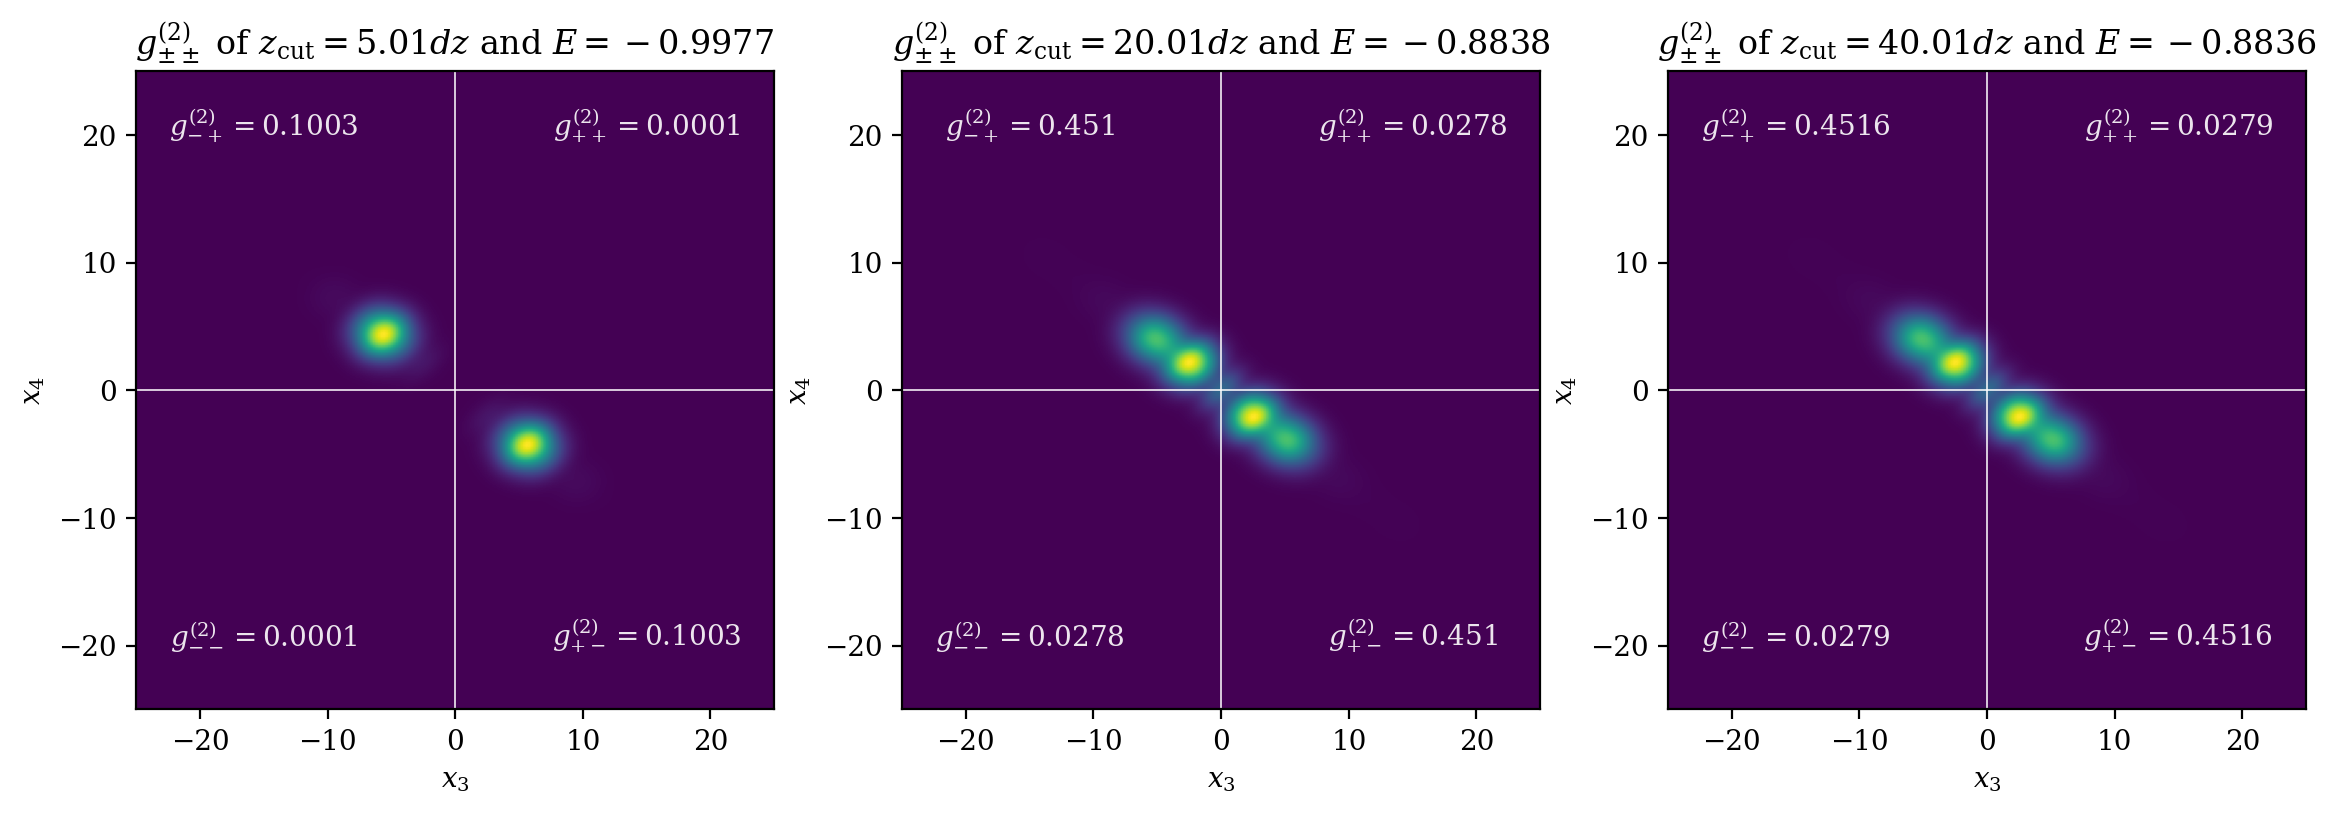

In [53]:
assert False, "Catch auto runs"

AssertionError: Catch auto runs

In [52]:
t= total_steps*dt

### Generate Ring

In [127]:
del psi, phi

NameError: name 'psi' is not defined

In [49]:
gc.collect()

12650

angles_list = [0.     0.0312 0.0625 0.0938 0.125  0.1562 0.1875 0.2188 0.25   0.2812
 0.3125 0.3437 0.375  0.4063 0.4375 0.4687 0.5    0.5312 0.5625 0.5938
 0.625  0.6562 0.6875 0.7188 0.75   0.7812 0.8125 0.8438 0.875  0.9062
 0.9375 0.9688] * pi


  0%|                                                                                                         …

t = -1.00000 		 frame = -1 		 memory used: 18585.354MB  


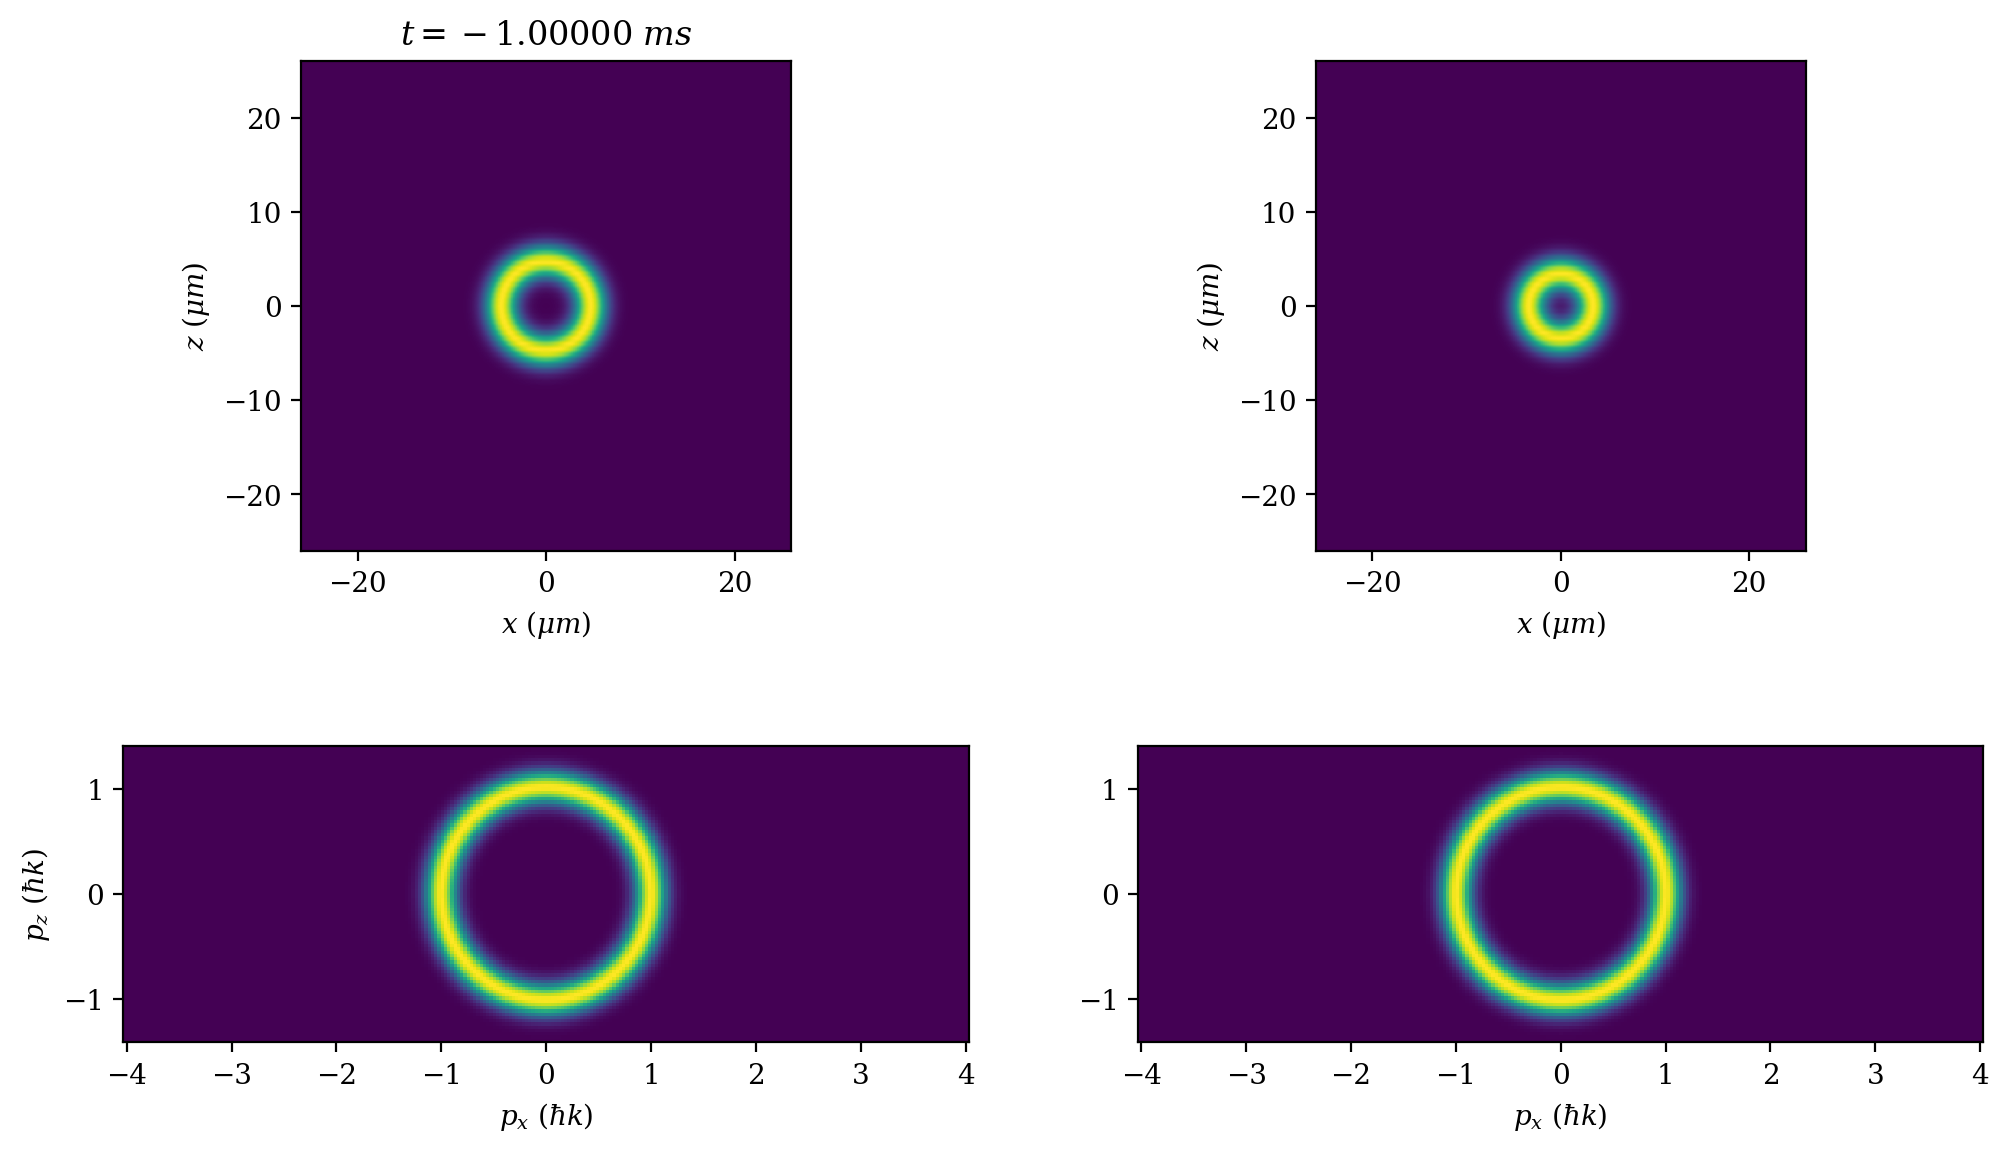

In [50]:
psi = psi0ring_with_logging(arg_dr=5,arg_s3=1.7,arg_s4=1.7,arg_pt=hb*k,arg_an=32)

# psi = psi0Pair(dr=10,s3=1.7,s4=1.6,pt=hb*k,a=0.0*pi,nx=nx,nz=nz)
phi, swnf = phiAndSWNF(psi, nthreads=7)
scattering_evolve_loop_plot(-1,-1,psi,phi,
                            plt_show=True,plt_save=False,plt_save_func_name="generated_entangled_ring")

In [148]:
del psi

NameError: name 'psi' is not defined

In [149]:
del phi

In [150]:
gc.collect()

23750

In [151]:
with pgzip.open('output/entangled_halo_proj/(20230212-131359-F) (psi0ring(5, 1.7, 1.7, hb*k, 32)).pgz.pkl', 'rb', thread=8) as file:
    psi = pickle.load(file)
phi, swnf = phiAndSWNF(psi, nthreads=7)
t = 0

#### Saved fig

`psi0ring_with_logging(arg_dr=5,arg_s3=1.7,arg_s4=1.7,arg_pt=hb*k,arg_an=32)`
`/output/entangled_halo_proj/(20230212-131359-F) (psi0ring(5, 1.7, 1.7, hb*k, 32)).pgz.pkl`
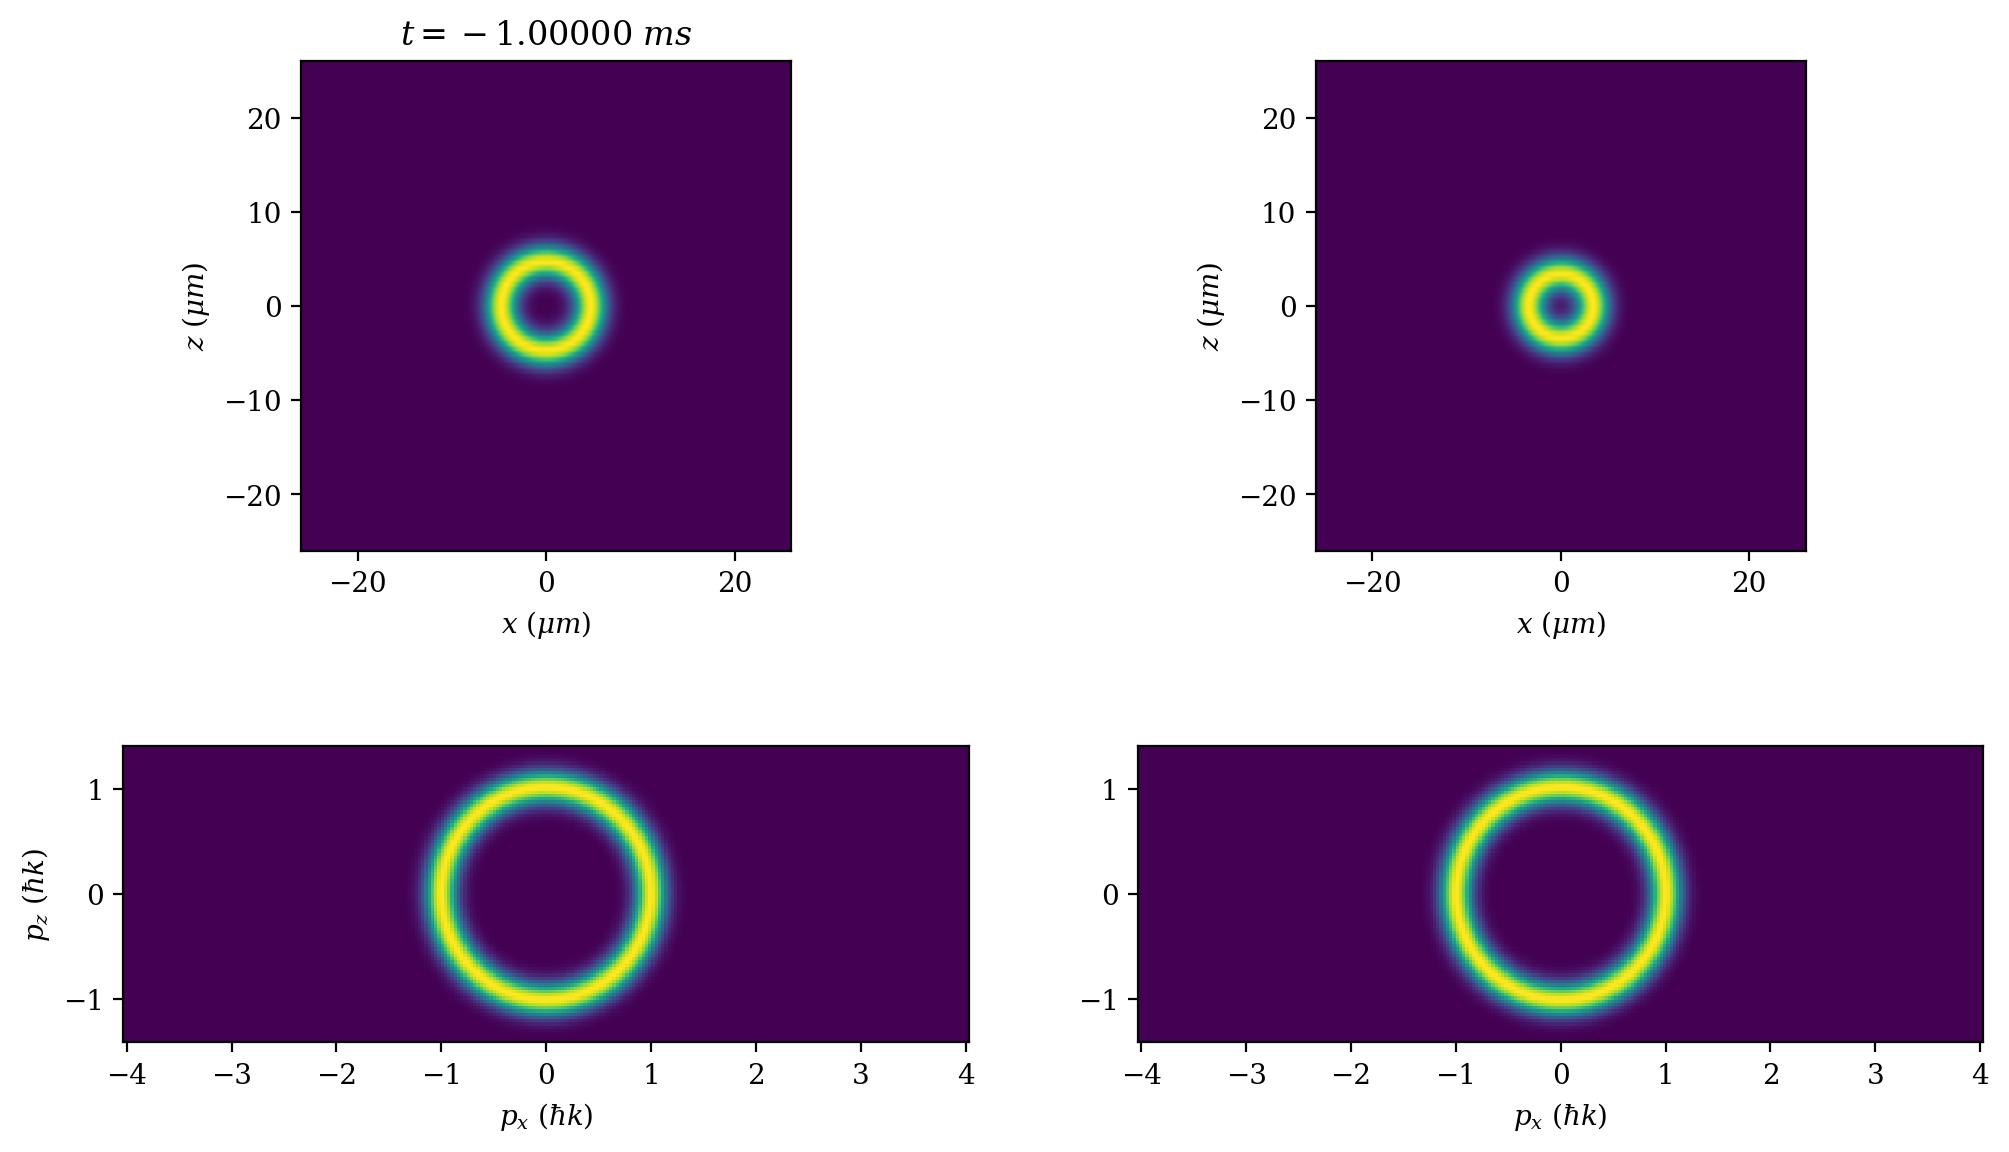
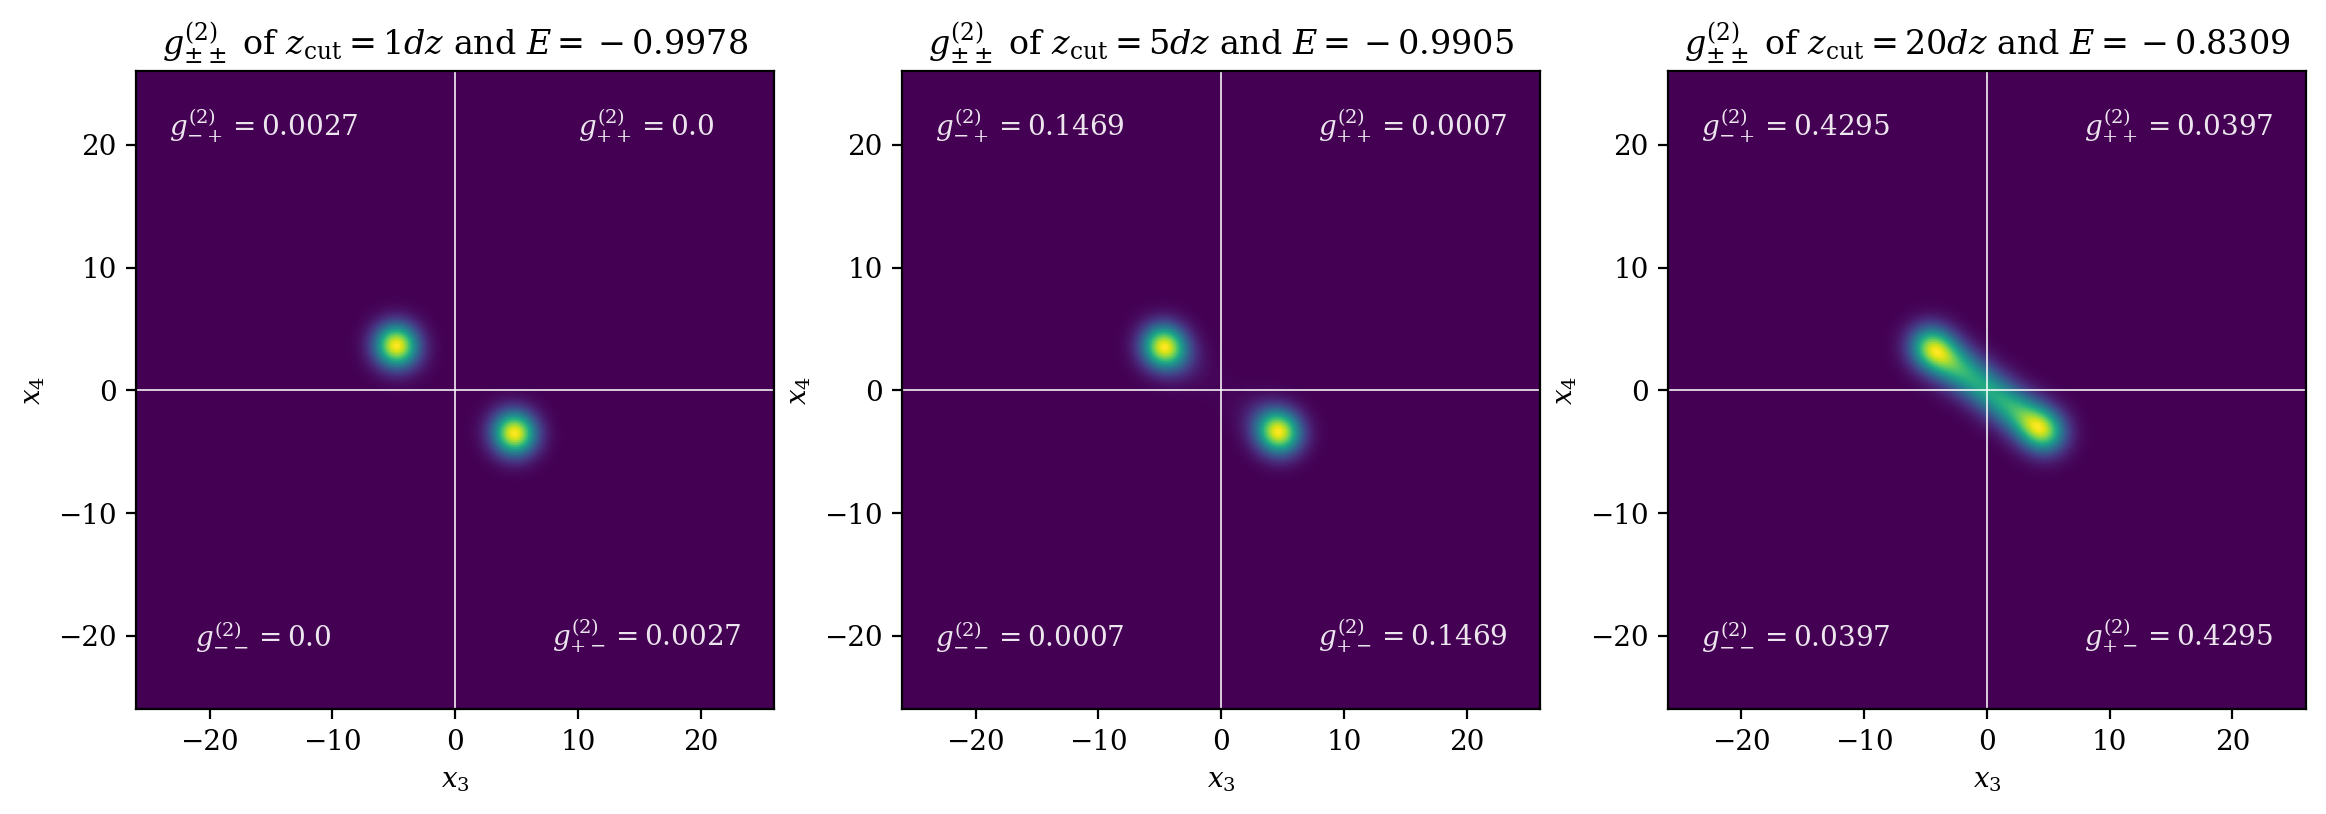

##### Older Save fig

`psi = psi0Pair(dr=10,s3=1.7,s4=1.6,pt=hb*k,a=0.5*pi,nx=nx,nz=nz)`
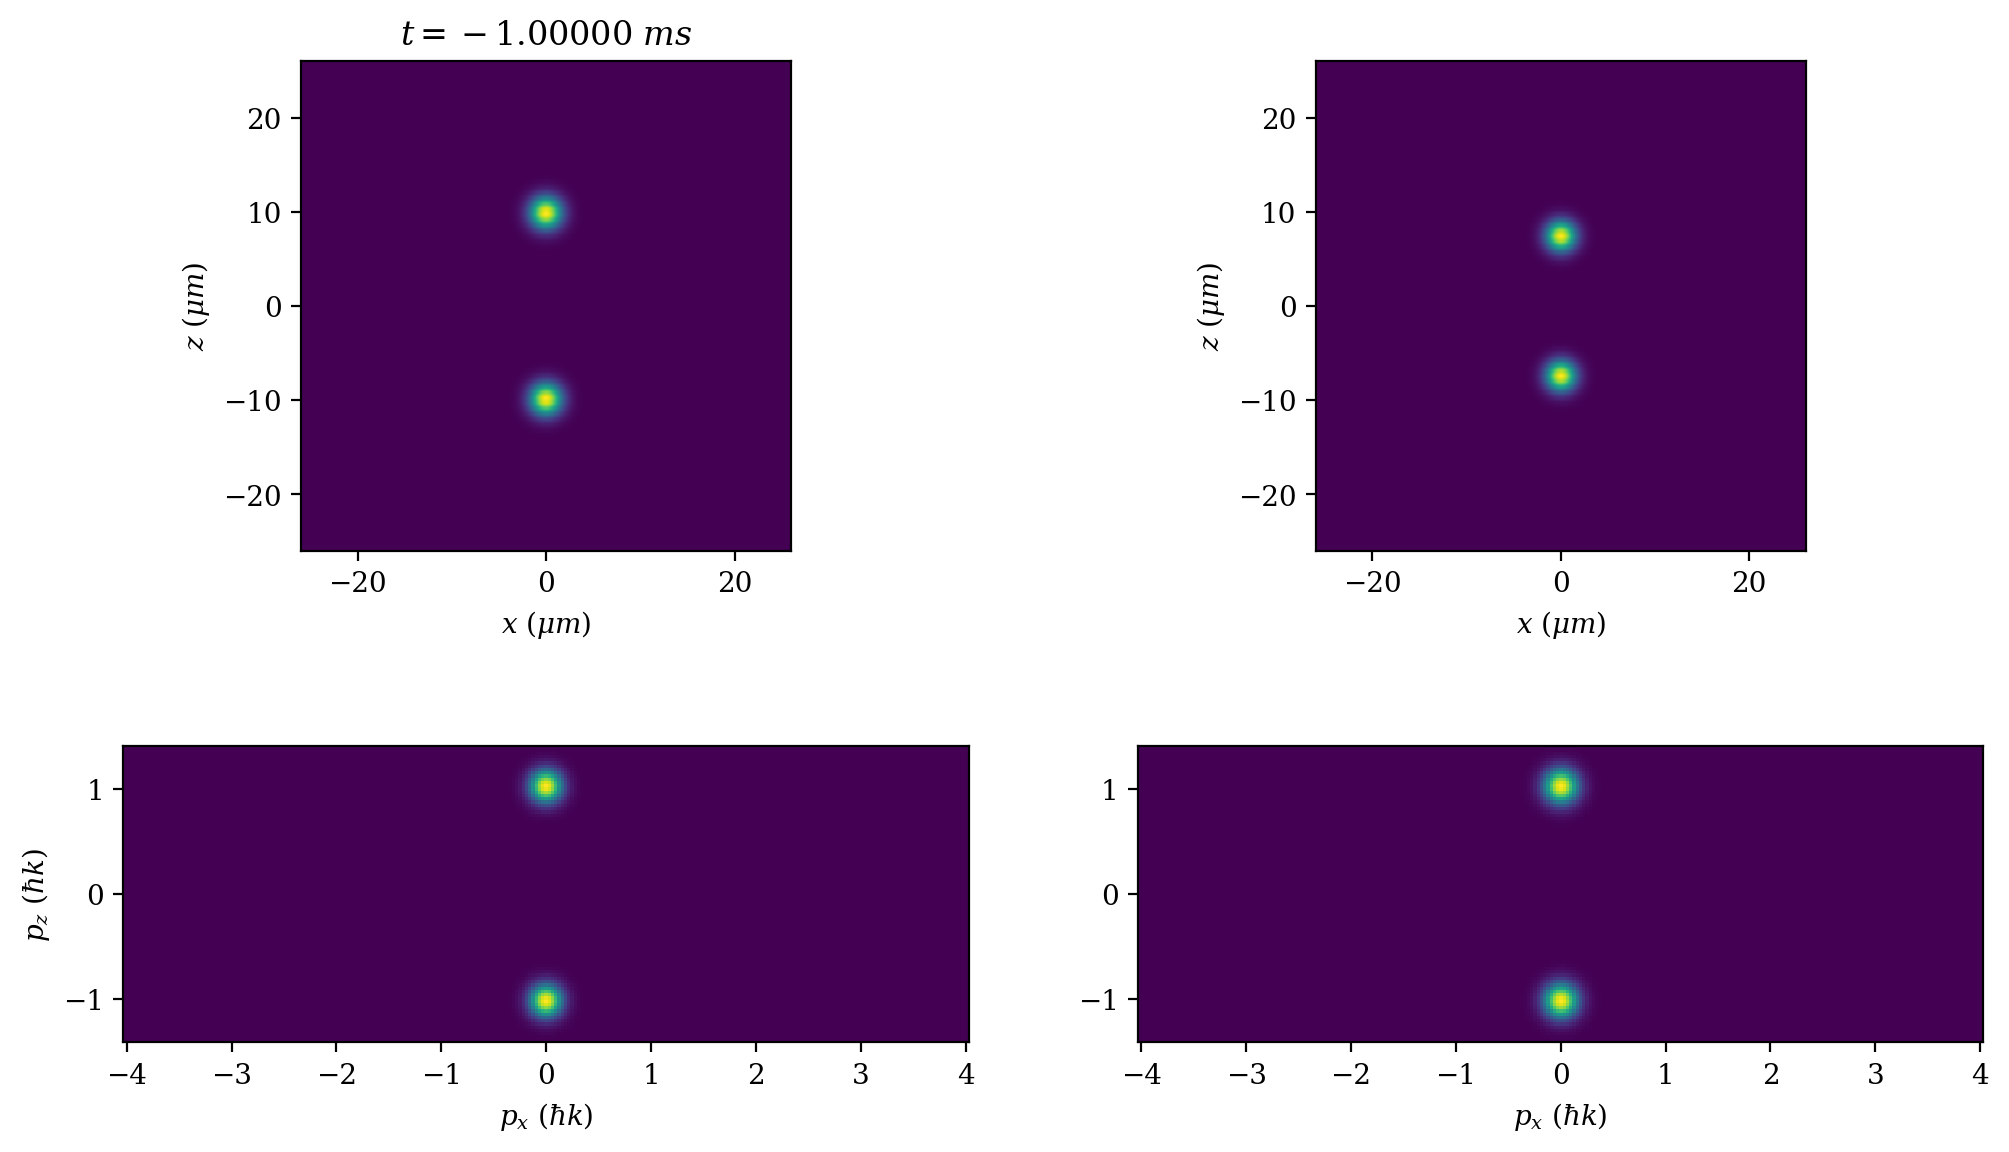



`psi = psi0ring_with_logging(dr=10,s3=1.7,s4=1.7,pt=hb*k,an=1)`
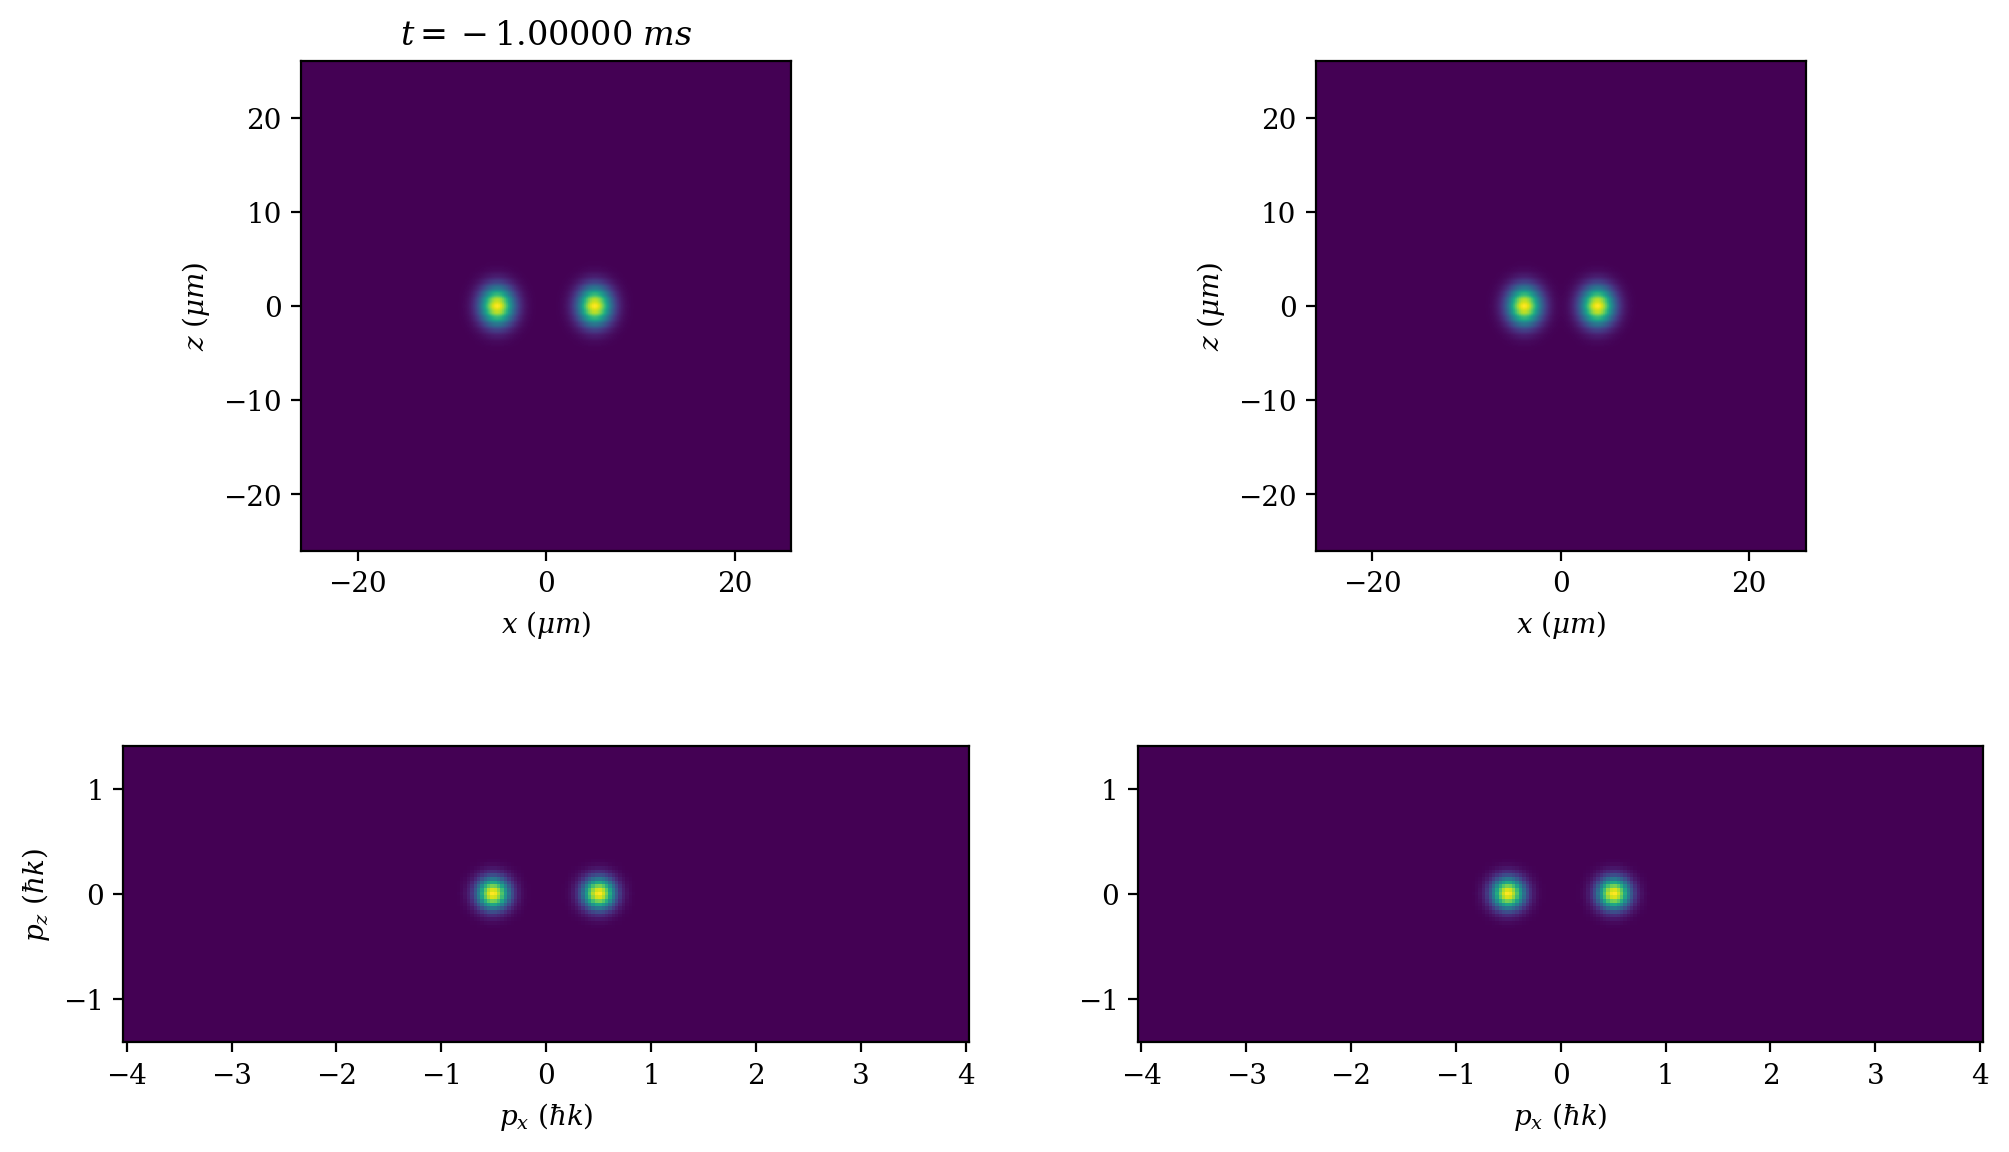


`psi = psi0Pair(dr=10,s3=1.7,s4=1.6,pt=hb*k,a=0.0*pi,nx=nx,nz=nz)`
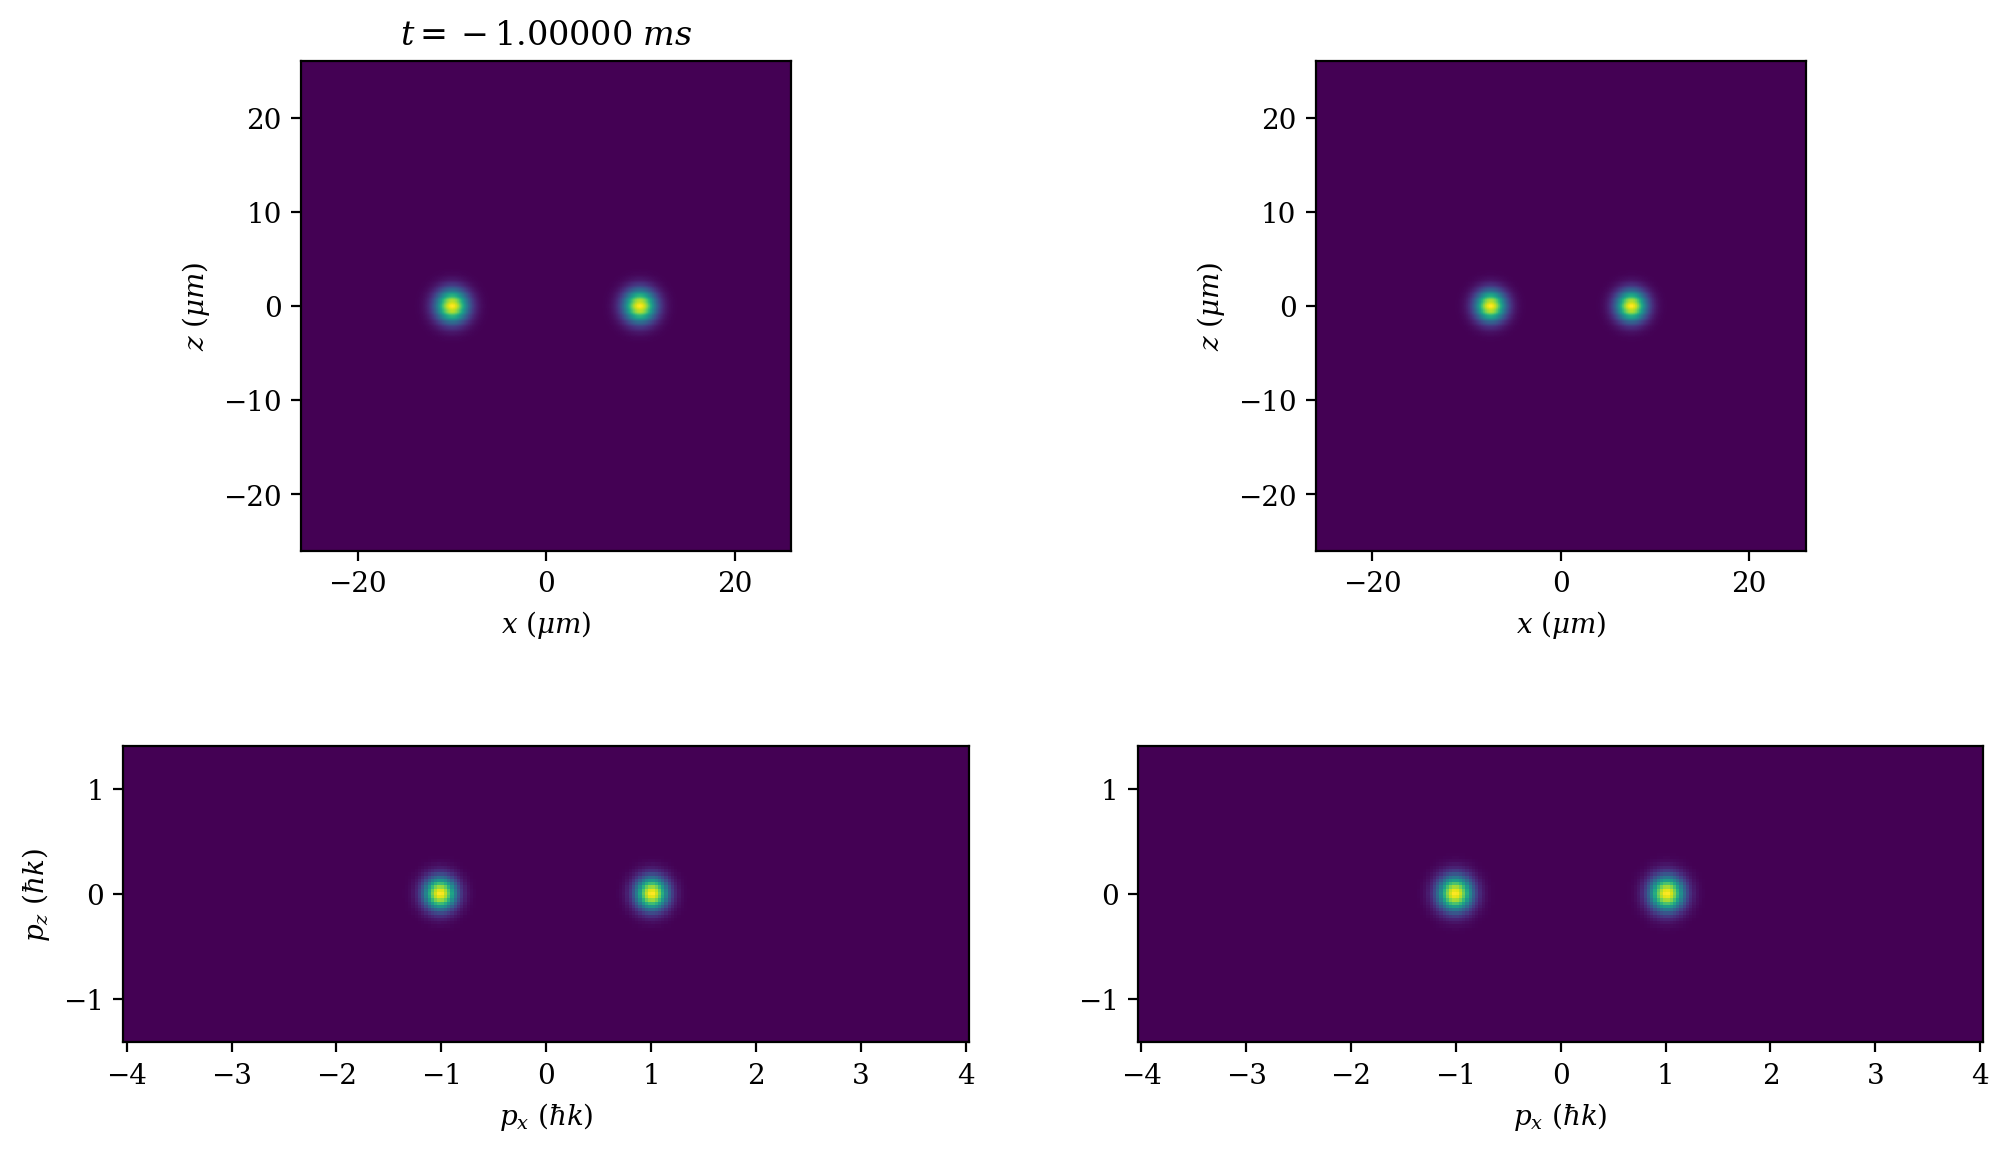

## Bragg Time Evolution Operator

### old code

Notes

`V0FArg=1*V0F, phase=0, doppd=-10*dopd` doesn't quite work with `tauPi = 0.0039`

`V0FArg=2*V0F, phase=0, doppd=-10*dopd` worked ish

`V0FArg=3*V0F, phase=0, doppd=-10*dopd` worked

`V0FArg=4*V0F, phase=0, doppd=-10*dopd` worked

`V0FArg=10*V0F, phase=0, doppd=-10*dopd` might be too fast

The problem with these are they don't have transfers

then I realised I set the doppler frequency different incorrectly ....

### New Code

In [152]:
t = total_steps * dt
t = 0

In [153]:
abs(t - total_steps * dt) < 0.00000001

False

In [154]:
tau4Pi1  = 9.3*0.001
tau4Mid1 = tau4Pi1*5
tau4End1 = tau4Pi1*10

tau4Pi2  = 5.2*0.001
tau4Mid2 = tau4Pi2*5
tau4End2 = tau4Pi2*10

# tau3Pi1  = 9.0*0.001
tau3Pi1  = tau4Pi1
tau3Mid1 = tau3Pi1*5
tau3End1 = tau3Pi1*10

# tau3Pi2  = 5.3*0.001
tau3Pi2  = tau4Pi2
tau3Mid2 = tau3Pi2*5
tau3End2 = tau3Pi2*10


tMirMid = t + max(tau4Mid1, tau3Mid1)
tMirEnd = t + max(tau4End1, tau3End1)


tMix = 0.165
phase0 = 1.54
phasePi = 1.54*3+0.09
phasePi2 = 0
phasePi4 = 1.54*0.25+0.13

# tauMixBeg = tMix - tau4Pi2*5
# tauMixMid = tMix
# tauMixEnd = tMix + tau4Pi2*5

In [155]:
print(f"tMirMid = {round(tMirMid,8)}")
print(f"tMirEnd = {round(tMirEnd,8)}")
stepsBragg = int((tMirEnd-t)/dt)
print(f"stepsBragg = {round((tMirEnd-t)/dt,8)} -> (to int: {stepsBragg})")
frames_count_bragg = stepsBragg // print_every
print(f"frames_count_bragg = {round(stepsBragg / print_every,8)} -> (to int: {frames_count_bragg})")

tMirMid = 0.0465
tMirEnd = 0.093
stepsBragg = 186.0 -> (to int: 186)
frames_count_bragg = 93.0 -> (to int: 93)


In [156]:
VBF(t+tau4Mid1,tMirMid, tau4Pi1, V0F)

19947.114020071636

In [157]:
numba.set_num_threads(7)

In [158]:
# @njit(parallel=True,cache=True)
@jit(cache=True) #Otherwise causes an error I don't know how to solve
def bragg_evolve_helper_psi_step(t,psi_init,tw3,tc3,tw4,tc4,ph3,ph4,V3,V4,dop3,dop4):
    psi = psi_init
    cosX3Lin = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tc3,tw3,V3) * \
                        np.cos(2*k*xlin + dop3*(t-tc3) + ph3) )
    cosX4Lin = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tc4,tw4,V4) * \
                        np.cos(2*k*xlin + dop4*(t-tc4) + ph4) )
    for iz3 in prange(nz):
        z3 = zlin[iz3]
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] *= cosX3Lin
    for ix3 in prange(nx):
        x3 = xlin[ix3]
        for (iz3, z3) in enumerate(zlin):
            for (iz4, z4) in enumerate(zlin):
                psi[ix3,iz3,:,iz4] *= cosX4Lin
    return psi

@jit(nogil=True, forceobj=True)
def bragg_evolve_helper_step(t_init,psi_init,tw3,tc3,tw4,tc4,ph3,ph4,V3,V4,dop3,dop4,
                             swnf,steps,
                             progress_proxy=None):
    t = t_init
    psi = psi_init
    for ia in prange(steps):
        psi = bragg_evolve_helper_psi_step(t,psi,tw3,tc3,tw4,tc4,ph3,ph4,V3,V4,dop3,dop4)
        phi = toPhi(psi,swnf,nthreads=7)
        phi = scattering_evolve_loop_helper2_inner_phi_step(phi)
        psi = toPsi(phi,swnf,nthreads=7)
        psi = bragg_evolve_helper_psi_step(t,psi,tw3,tc3,tw4,tc4,ph3,ph4,V3,V4,dop3,dop4)
        t+=dt
        if progress_proxy != None: progress_proxy.update(1)
    return (t,psi,phi)

In [146]:
# fb = 0
# with ProgressBar(total=stepsBragg) as progressbar:
#     for fb in range(frames_count_bragg):
#         scattering_evolve_loop_plot(t,fb,psi,phi,
#                                     plt_show=False, plt_save=True,plt_save_func_name="bragg_mirror")
#         del phi # slower but saves memory
#         gc.collect()
#         (t,psi,phi) = bragg_evolve_helper_step(t_init=t,psi_init=psi,
#                                                tw3=tau3Pi1,tc3=tMirMid,
#                                                tw4=tau4Pi1,tc4=tMirMid,
#                                                ph3=0,ph4=0,
#                                                V3=0.4*V0F,V4=0.4*V0F,
#                                                dop3=0,dop4=0,
#                                                swnf=swnf,
#                                                steps=print_every,
#                                                progress_proxy=progressbar
#                                               )
#         gc.collect()
        
# scattering_evolve_loop_plot(t,fb+1,psi,phi,
#                             plt_show=False,plt_save=True,plt_save_func_name="bragg_mirror")

  0%|                                                                                                         …

t = 0.09300 		 frame = 93 		 memory used: 19293.815MB  


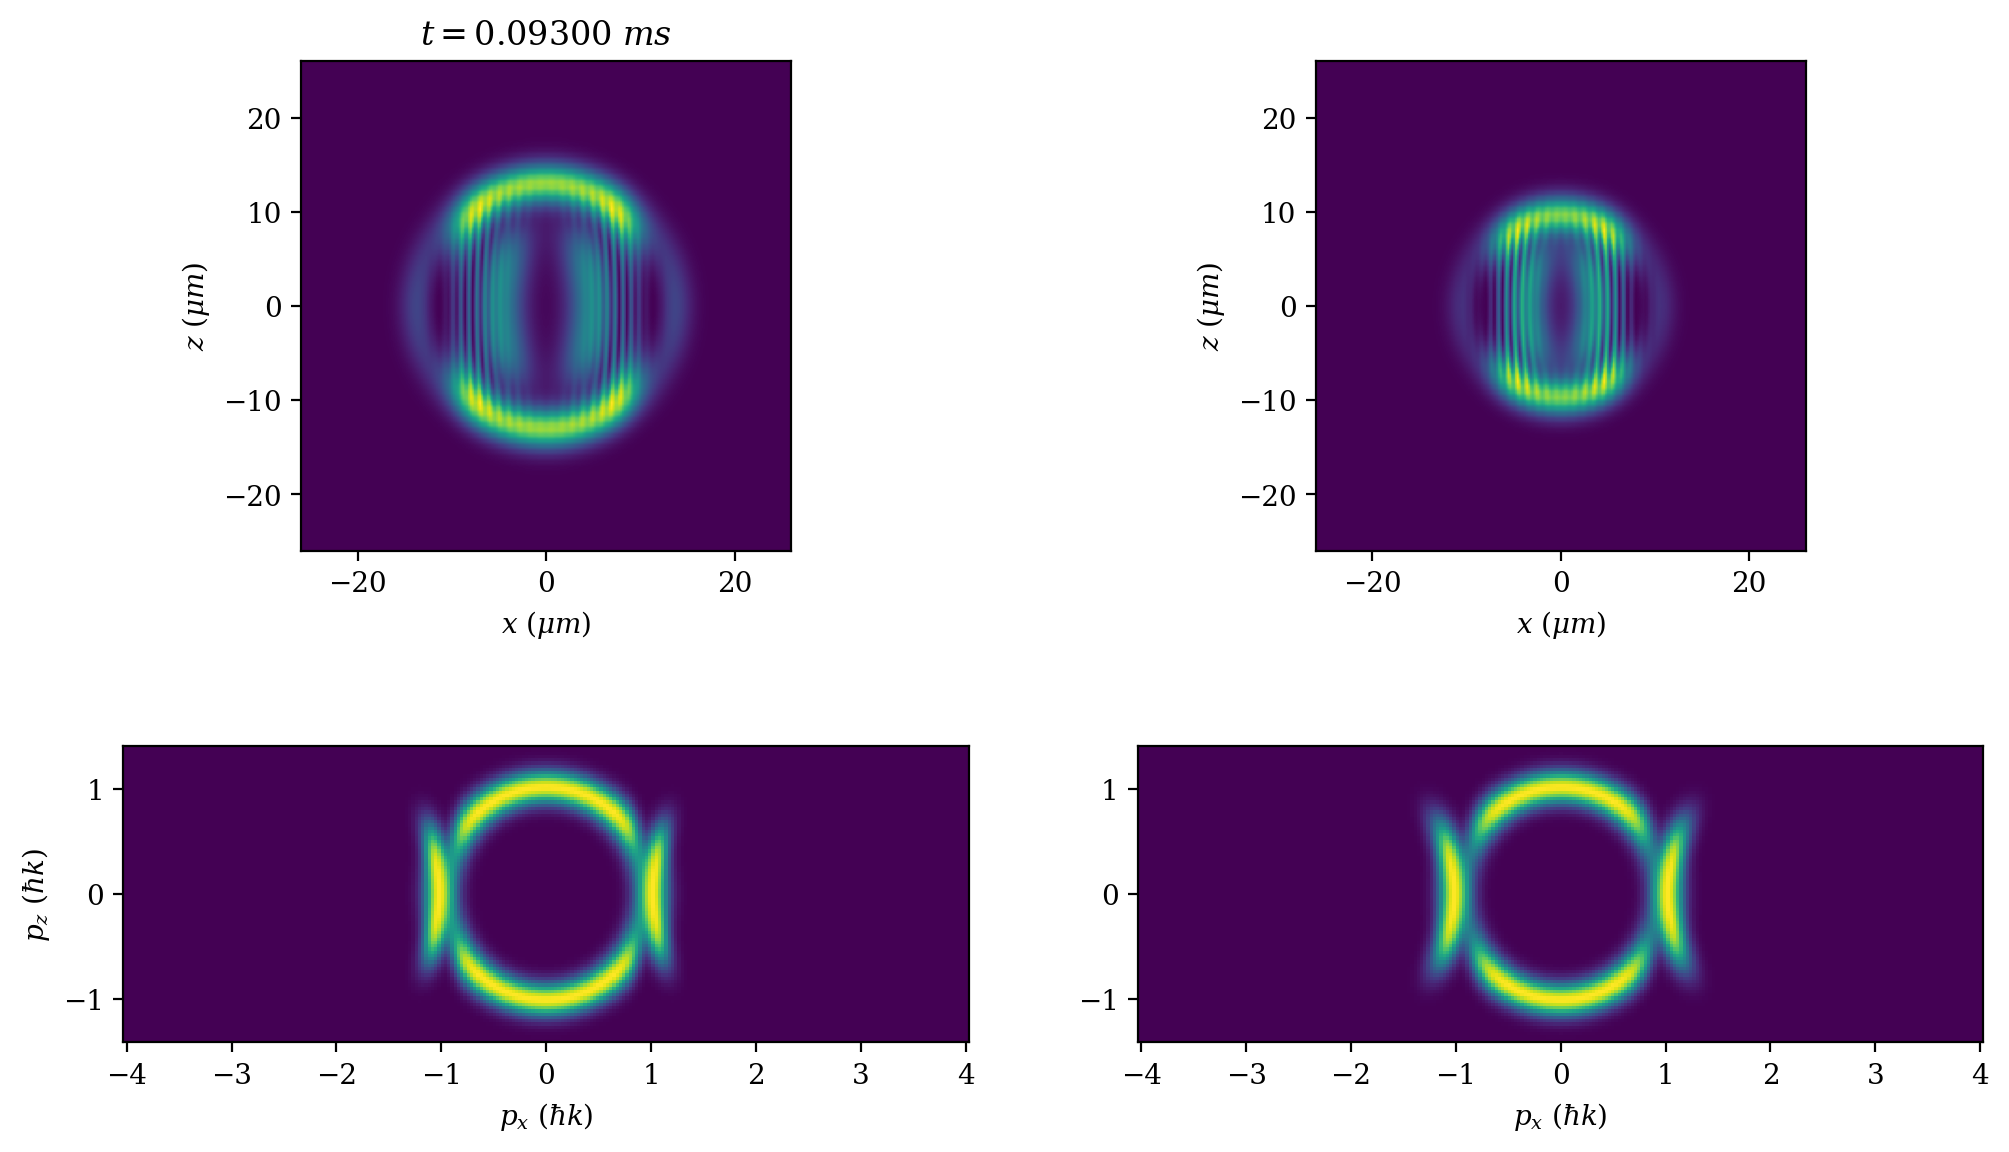

In [159]:
fb = 0
with ProgressBar(total=stepsBragg) as progressbar:
    for fb in range(frames_count_bragg):
        scattering_evolve_loop_plot(t,fb,psi,phi,
                                    plt_show=False, plt_save=True,plt_save_func_name="bragg_mirror")
        del phi # slower but saves memory
        gc.collect()
#         (t,psi,phi) = bragg_evolve_helper_step(t_init=t,psi_init=psi,
#                                                tw3=tau3Pi1,tc3=tMirMid,
#                                                tw4=tau4Pi1,tc4=tMirMid,
#                                                ph3=0,ph4=0,
#                                                V3=0.4*V0F,V4=0.4*V0F,
#                                                dop3=0,dop4=0,
#                                                swnf=swnf,
#                                                steps=print_every,
#                                                progress_proxy=progressbar
#                                               )
        for ia in prange(print_every):
            cosX3Lin = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tMirMid,tau3Pi1,0.4*V0F) * \
                                np.cos(2*k*xlin + 0*(t-tMirMid) + 0) )
            cosX4Lin = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tMirMid,tau4Pi1,0.4*V0F) * \
                                np.cos(2*k*xlin + 0*(t-tMirMid) + 0) )
            
            psi = bragg_evolve_helper_psi_step(t=t,psi_init=psi,
                                               tw3=tau3Pi1,tc3=tMirMid,
                                               tw4=tau4Pi1,tc4=tMirMid,
                                               ph3=0,ph4=0,
                                               V3=0.4*V0F,V4=0.4*V0F,
                                               dop3=0,dop4=0
                                              )
#             for iz3 in prange(nz):
#                 z3 = zlin[iz3]
#                 for (ix4, x4) in enumerate(xlin):
#                     for (iz4, z4) in enumerate(zlin):
#                         psi[:,iz3,ix4,iz4] *= cosX3Lin
#             for ix3 in prange(nx):
#                 x3 = xlin[ix3]
#                 for (iz3, z3) in enumerate(zlin):
#                     for (iz4, z4) in enumerate(zlin):
#                         psi[ix3,iz3,:,iz4] *= cosX4Lin

            phi = toPhi(psi,swnf,nthreads=7)
            
            del psi
            
            phi = scattering_evolve_loop_helper2_inner_phi_step(phi)
#             for (iz3, pz3) in enumerate(pzlin):
#                 for (ix4, px4) in enumerate(pxlin):
#                     for (iz4, pz4) in enumerate(pzlin):
#                         phi[:,iz3,ix4,iz4] *= np.exp(-(1j/hb) * (0.5/m3) * (dt) * (pxlin**2 + pz3**2) \
#                                                        -(1j/hb) * (0.5/m4) * (dt) * (  px4**2 + pz4**2))
            
            psi = toPsi(phi,swnf,nthreads=7)
            psi = bragg_evolve_helper_psi_step(t=t,psi_init=psi,
                                               tw3=tau3Pi1,tc3=tMirMid,
                                               tw4=tau4Pi1,tc4=tMirMid,
                                               ph3=0,ph4=0,
                                               V3=0.4*V0F,V4=0.4*V0F,
                                               dop3=0,dop4=0
                                              )
#             for iz3 in prange(nz):
#                 z3 = zlin[iz3]
#                 for (ix4, x4) in enumerate(xlin):
#                     for (iz4, z4) in enumerate(zlin):
#                         psi[:,iz3,ix4,iz4] *= cosX3Lin
#             for ix3 in prange(nx):
#                 x3 = xlin[ix3]
#                 for (iz3, z3) in enumerate(zlin):
#                     for (iz4, z4) in enumerate(zlin):
#                         psi[ix3,iz3,:,iz4] *= cosX4Lin
            
            t+=dt
            if progressbar != None: progressbar.update(1)
        
        gc.collect()
        
scattering_evolve_loop_plot(t,fb+1,psi,phi,
                            plt_show=True,plt_save=True,plt_save_func_name="bragg_mirror")

In [161]:
t 

0.09300000000000007

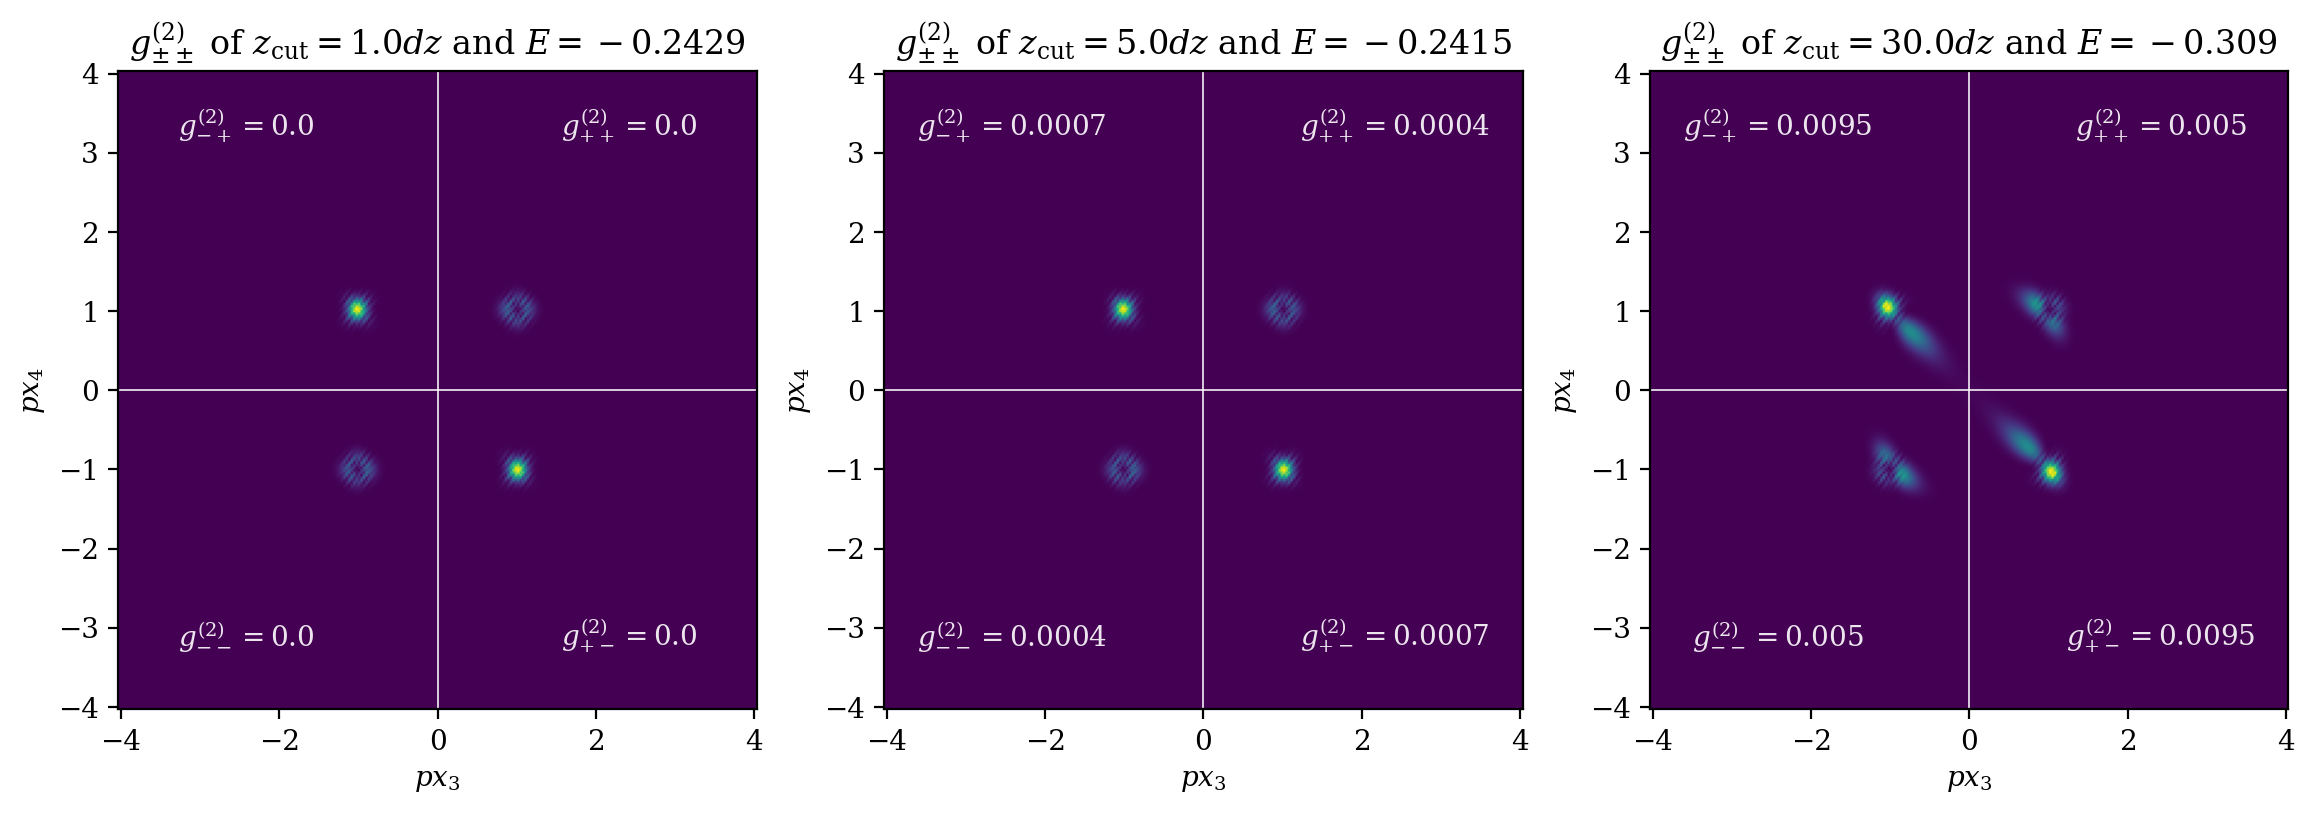

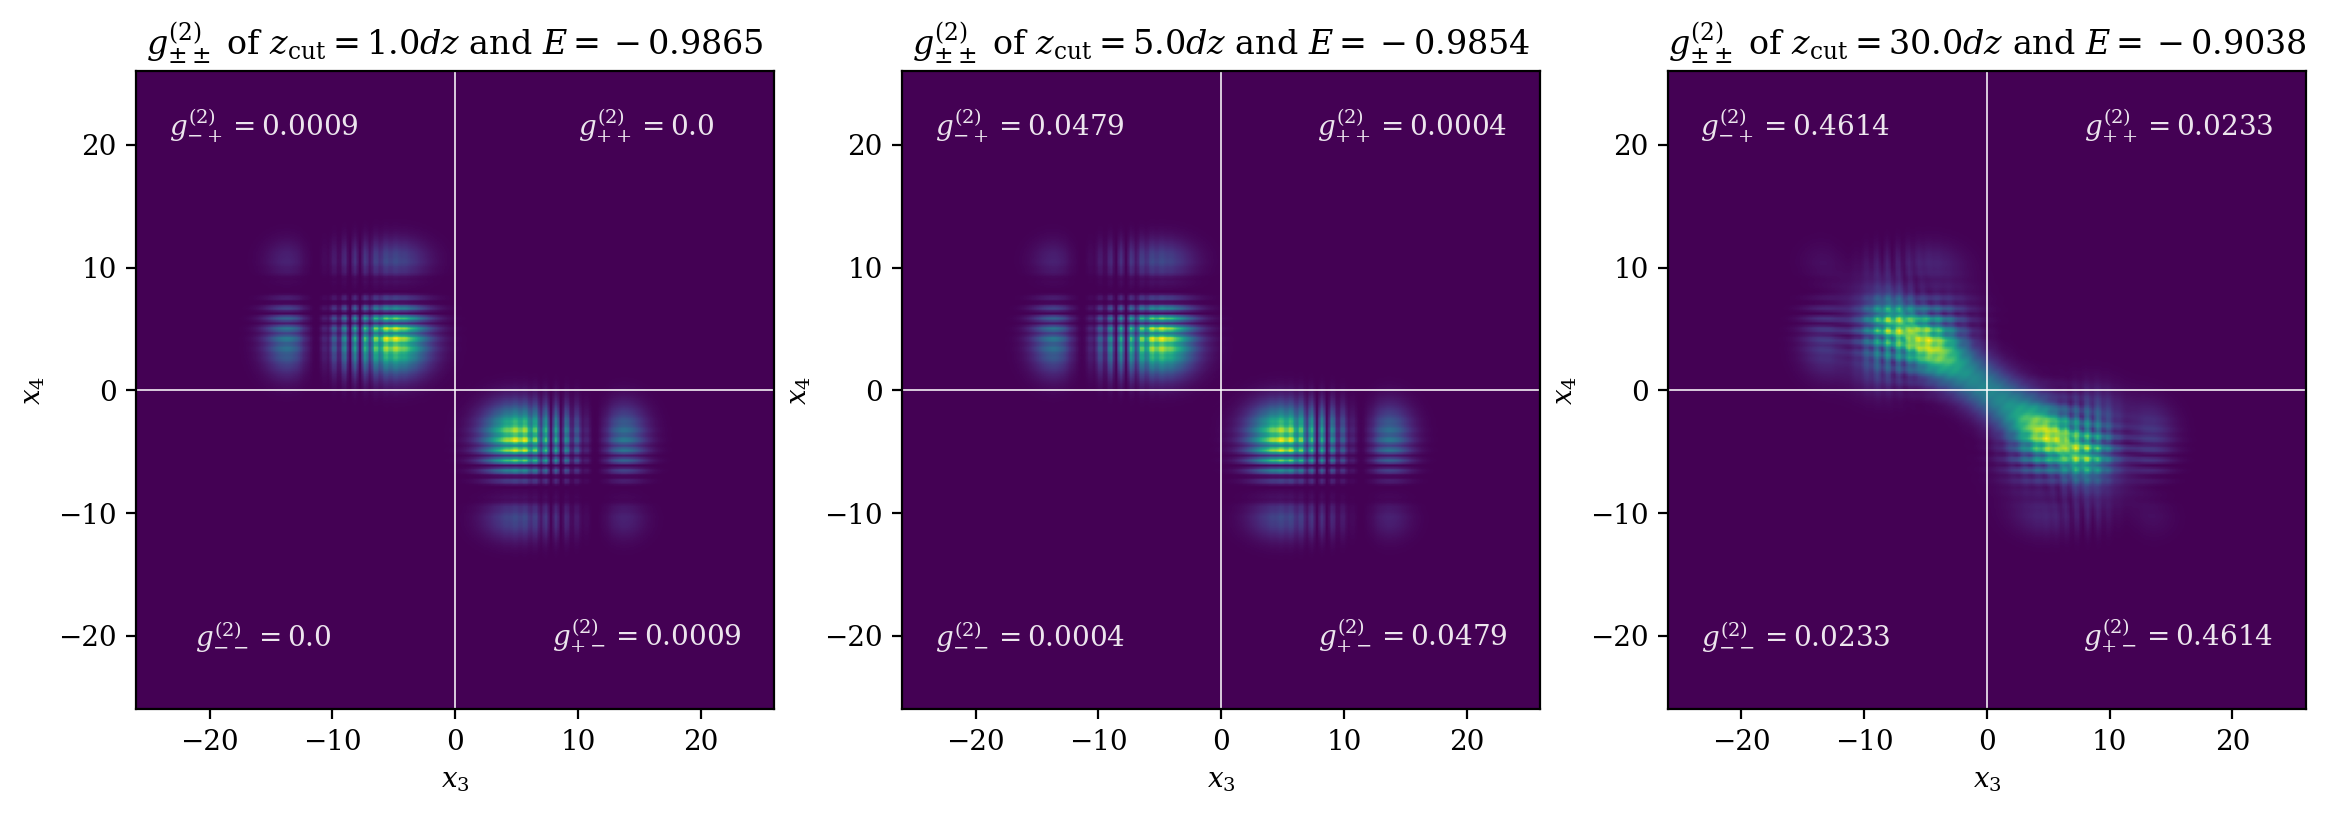

In [162]:
plt.figure(figsize=(14,6))

cut_list = [1.0, 5.0, 30.0]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(phi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4_phi(gx3x4,cut)
plt.show()
del gx3x4

plt.figure(figsize=(14,6))

cut_list = [1.0, 5.0, 30.0]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(psi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4(gx3x4,cut)
plt.show()
del gx3x4

In [32]:
hbar_k_transfers = np.arange(-6,6+1)
pzlinIndexSet = np.zeros((len(hbar_k_transfers), len(pxlin)), dtype=bool)
# cut_p_width = 0.1
lr_include = 1
for (j, hbar_k) in enumerate(hbar_k_transfers):
#     pzlinIndexSet[j] = abs(pxlin/(hb*k) - hbar_k) <= cut_p_width

    index_unshift = round(hbar_k*(hb*k)/dpx)
    index = int(index_unshift + (nx-1)/2)
    for ishift in range(-lr_include, lr_include+1):
        pzlinIndexSet[j,index+ishift] = True
    
#     print(i,hbar_k, index)

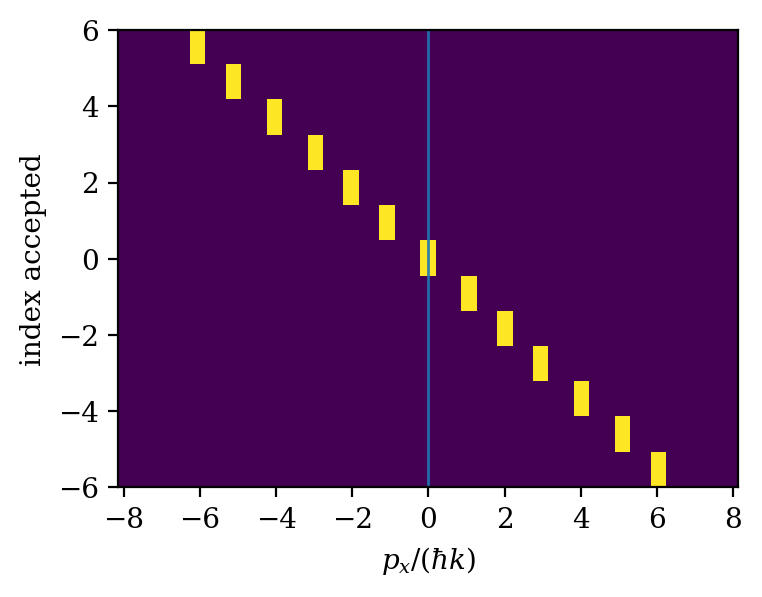

In [33]:
# plt.figure()
ax = plt.figure(figsize=(4,4)).gca()
plt.imshow(pzlinIndexSet,interpolation='none',aspect=1, extent=[-pxmax/(hb*k),pxmax/(hb*k),-6,+6])
# plt.axvline(x=(nx-1)/2, linewidth=1, alpha=0.1)
plt.axvline(x=0, linewidth=1, alpha=0.9)
plt.xlabel("$p_x/(\hbar k)$")
plt.ylabel("index accepted")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

title="hbar_k_pxlin_integration_range"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

In [40]:
phiDensityGrid_hbark = np.zeros(len(hbar_k_transfers))

In [43]:
phiX3 = np.trapz(np.trapz(np.trapz( (np.abs(phi_try1)**2) , pzlin,axis=3),pxlin,axis=2),pzlin,axis=1)
for (j, hbar_k) in enumerate(hbar_k_transfers):
    index = pzlinIndexSet[j]
    phiDensityGrid_hbark[j] = np.trapz(phiX3[index], pxlin[index])

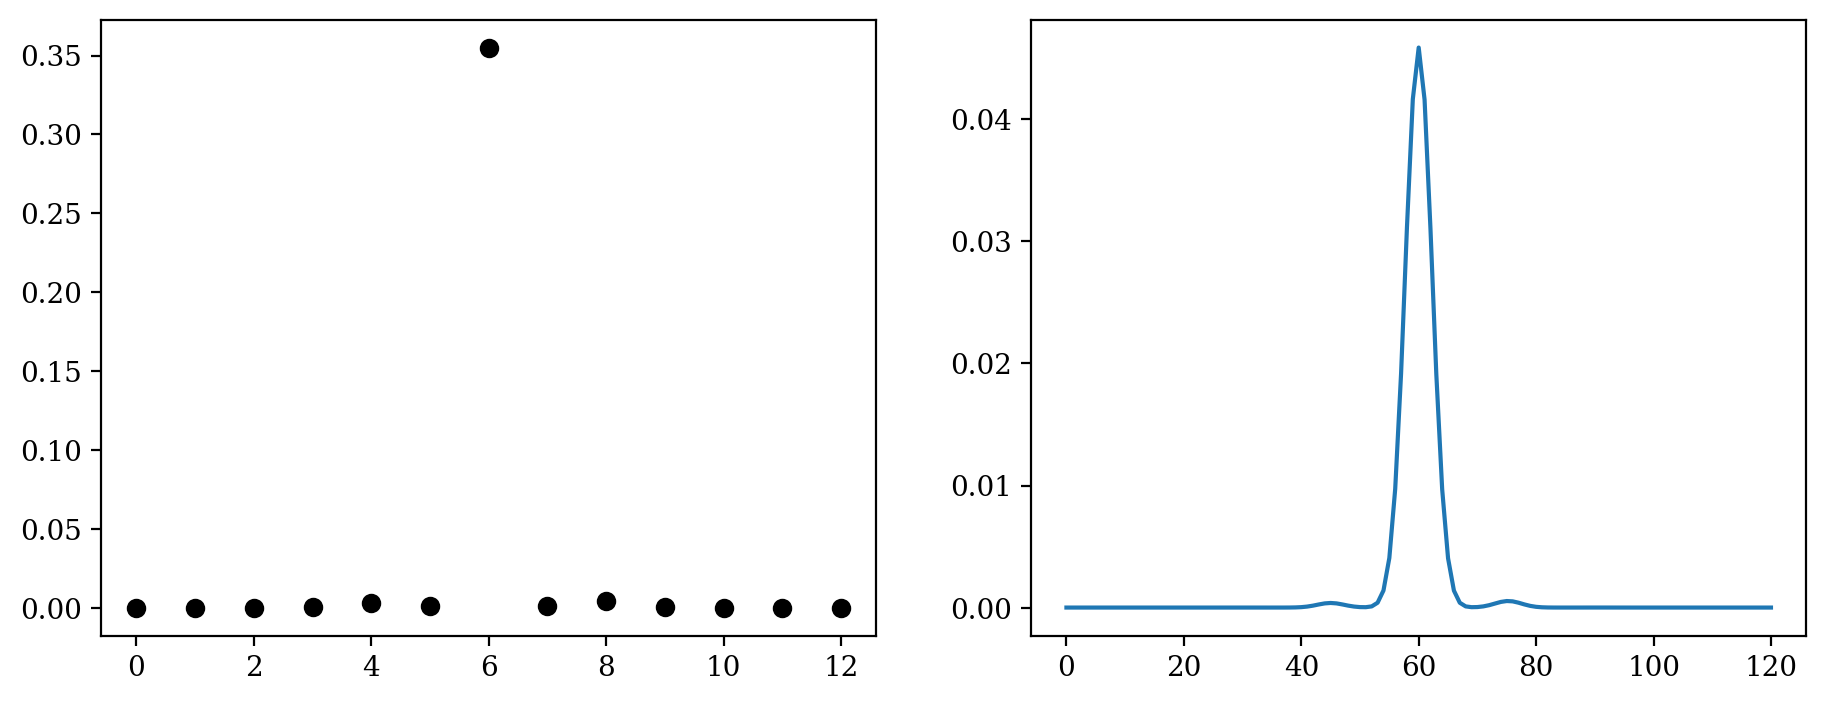

In [46]:
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(phiDensityGrid_hbark,'ko')
plt.subplot(1,2,2)
plt.plot(phiX3)

In [39]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [50]:
def scan_tauPi_init_gaussian(tPi, a3=0, a4=0, p3=0, p4=0, doppd=dopd, V0FArg=V0F, 
                             logging=False, progress_bar=False):
    tauPi  = tPi
    tauMid = tauPi * 5
    tauEnd = tauPi * 10
    px3 = p3*cos(a3)
    pz3 = p3*sin(a3)
    px4 = p4*cos(a4)
    pz4 = p4*sin(a4)
    
    if logging:
        print("Testing parameters")
        print("tauPi =", round(tPi,6), "    \t tauMid =", round(tauMid,6), " \t tauEnd = ", round(tauEnd,6))
    output = numericalEvolve(t_init=0, 
                psi_init=psi0gaussian(sx3=su, sz3=su, sx4=su, sz4=su, px3=px3, pz3=pz3, px4=px4, pz4=pz4), 
                t_final=tauEnd, tPi=tauPi, tMid=tauMid, V0FArg=V0FArg, phase=0, doppd=doppd, 
                print_every_t=0*dt, final_plot=False, progress_bar=progress_bar)
    

In [52]:
_ = scan_tauPi_init_gaussian(tauPi,a3=0,a4=0,p3=0,p4=0,doppd=-10*dopd,V0FArg=V0F,
                             logging=False,progress_bar=True)

  0%|          | 0/39 [00:00<?, ?it/s]

In [91]:
tPiTest = np.append(np.arange(0.015,0,-dt), 0) # note this is decending
    # tPiTest = np.arange(dt,3*dt,dt)  

In [92]:
tPiTest[[1,2,3]]

array([0.0145, 0.014 , 0.0135])

In [ ]:
tPiOutput = Parallel(n_jobs=N_JOBS)(
    delayed(lambda tPi: (tPi, scan_tauPi_init_gaussian(tPi,a3=0,a4=0,p3=0,p4=0,doppd=-10*dopd,V0FArg=V0F,
                             logging=False,progress_bar=True)
           )(tPi) 
    for tPi in tqdm(tPiTest)
)     

In [ ]:
phiDensityGrid = np.zeros((len(tPiTest), pxlin.size))
phiDensityGrid_hbark = np.zeros((len(tPiTest),len(hbar_k_transfers)))

for i in tqdm(range(len(tPiTest))):
    item = tPiOutput[i]
    (swnf, phi) = phiAndSWNF(item[1][1])
    phiAbsSq = np.abs(phi)**2
    phiX = np.trapz(phiAbsSq, pzlin,axis=1)
    phiDensityGrid[i] = phiX

    for (j, hbar_k) in enumerate(hbar_k_transfers):
        index = pzlinIndexSet[j]
        phiDensityGrid_hbark[i,j] = np.trapz(phiX[index], pxlin[index])

In [164]:
t

0.09300000000000007

## Free evolution

In [165]:
t_free_to_mix_c = tMix - dt*total_steps
t_free_to_mix_c = tMix - t
print("t after mirror:", t_free_to_mix_c)
print("in steps:", t_free_to_mix_c/dt)

t after mirror: 0.07199999999999994
in steps: 143.9999999999999


In [166]:
tMixMid = t + t_free_to_mix_c
print("time of centre of mixing in this frame:",tMixMid)

time of centre of mixing in this frame: 0.165


In [167]:
tMixBeg = tMixMid - tau4Pi2*5
tMixEnd = tMixMid + tau4Pi2*5

In [168]:
t_free_delta = tMixBeg - t
t_free_delta_steps = round(t_free_delta / dt)

tMix_steps = round(tau4Pi2*10/dt)

print("time delta: ", t_free_delta)
print("time steps: ", t_free_delta_steps)
print("mix steps:  ", tMix_steps)

time delta:  0.045999999999999944
time steps:  92
mix steps:   104


In [169]:
(tMixEnd-tMixBeg)/dt

103.99999999999999

t = 0.13900 		 frame = -1 		 memory used: 9117.663MB  


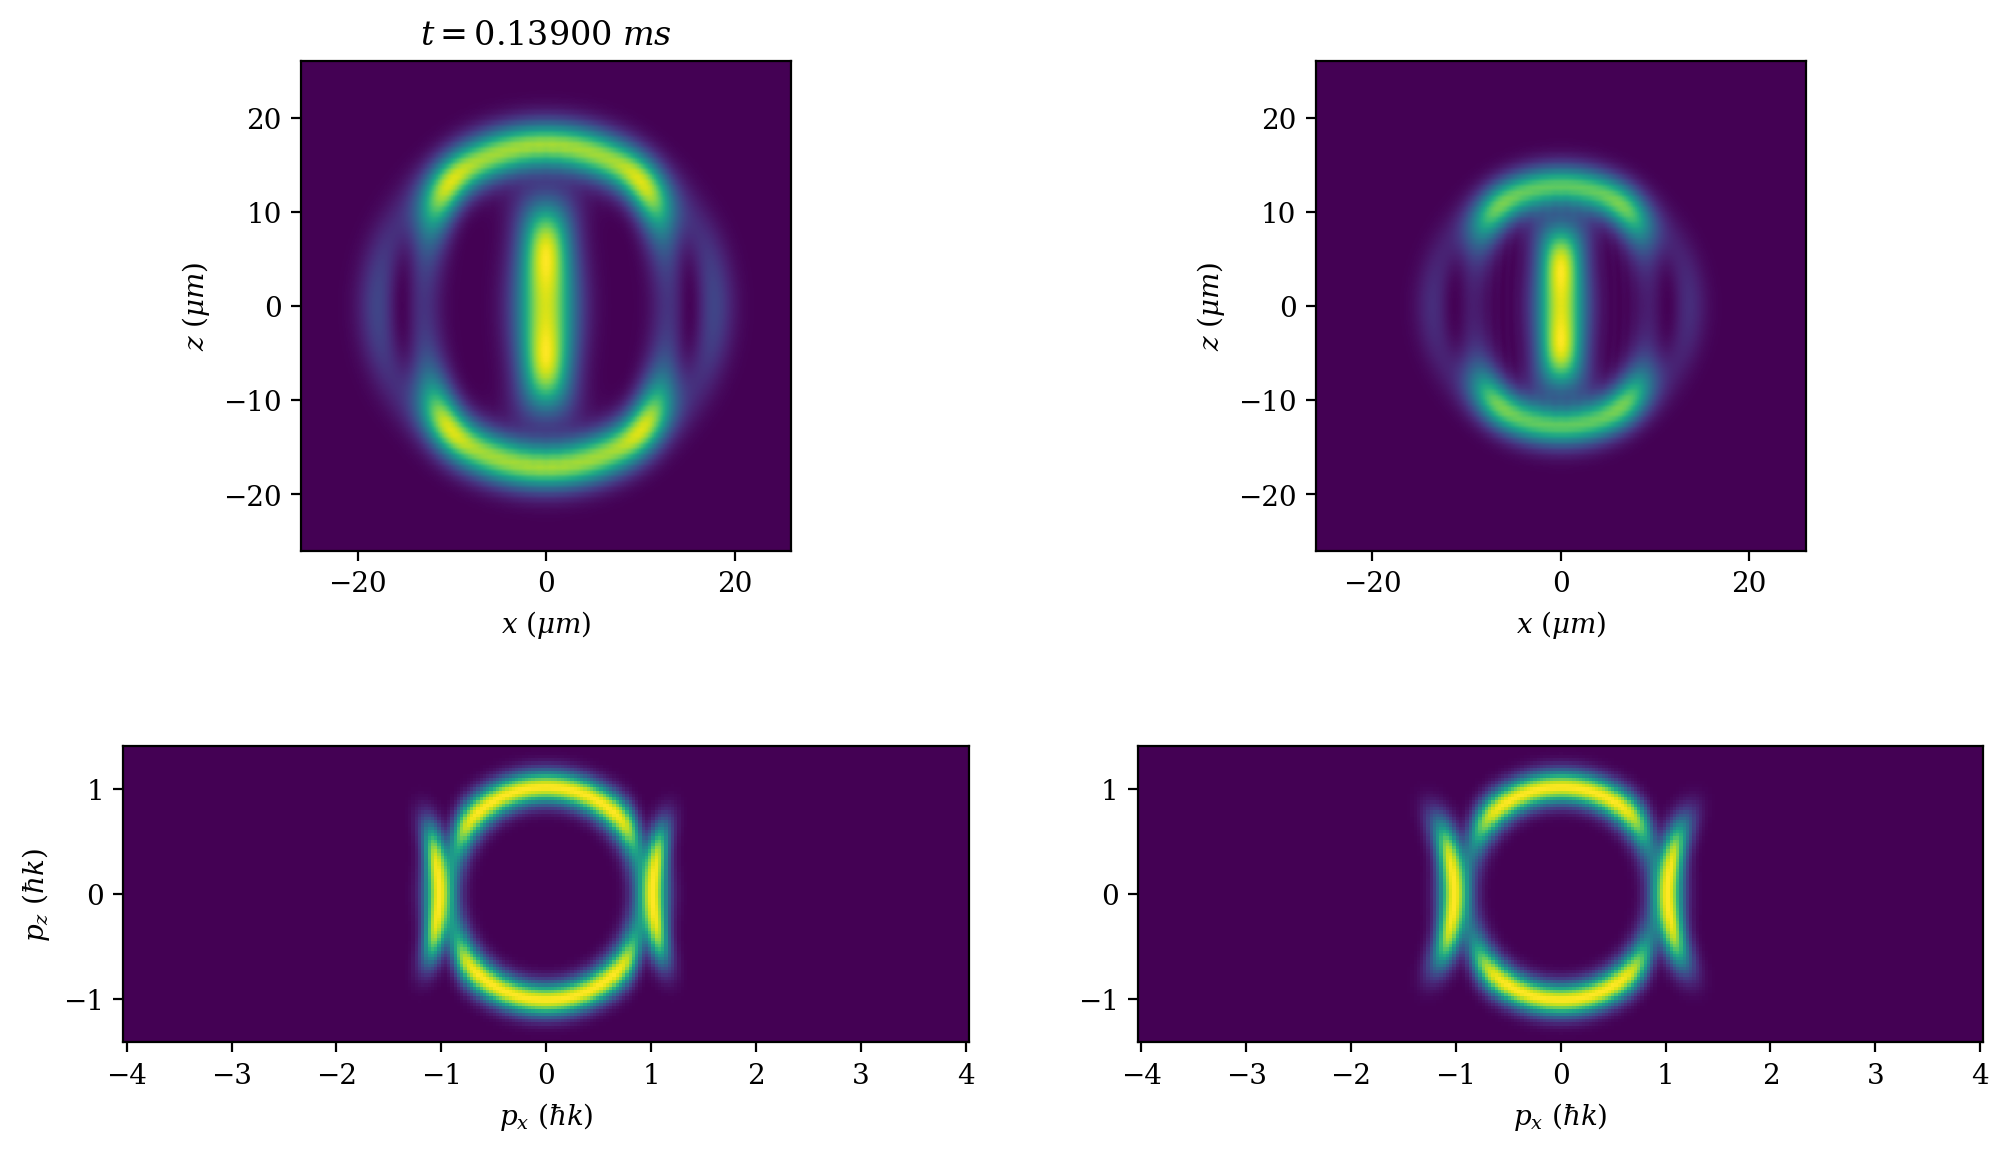

In [170]:
# assert False, "don't run yet"
for (iz3,pz3) in enumerate(pzlin):
    for (ix4,px4) in enumerate(pxlin):
        for (iz4,pz4) in enumerate(pzlin):
            phi[:,iz3,ix4,iz4] *= np.exp( -(1j/hb) * t_free_delta * (\
                                         (0.5/m3) * ( pxlin**2 + pz3**2) + \
                                         (0.5/m4) * ( px4**2   + pz4**2)  )
                                        )
psi = toPsi(phi,swnf,nthreads=7)
t = t + t_free_delta
scattering_evolve_loop_plot(t,-1,psi,phi,
                            plt_show=True,plt_save=True,plt_save_func_name="free_evolve")

In [171]:
t

0.139

In [172]:
tMixMid

0.165

## Final Mix Bragg

In [177]:
tMix_frames = tMix_steps // print_every
print(tMix_frames, tMix_steps)

52 104


  0%|                                                                                                         …

t = 0.19100 		 frame = 52 		 memory used: 19724.698MB  


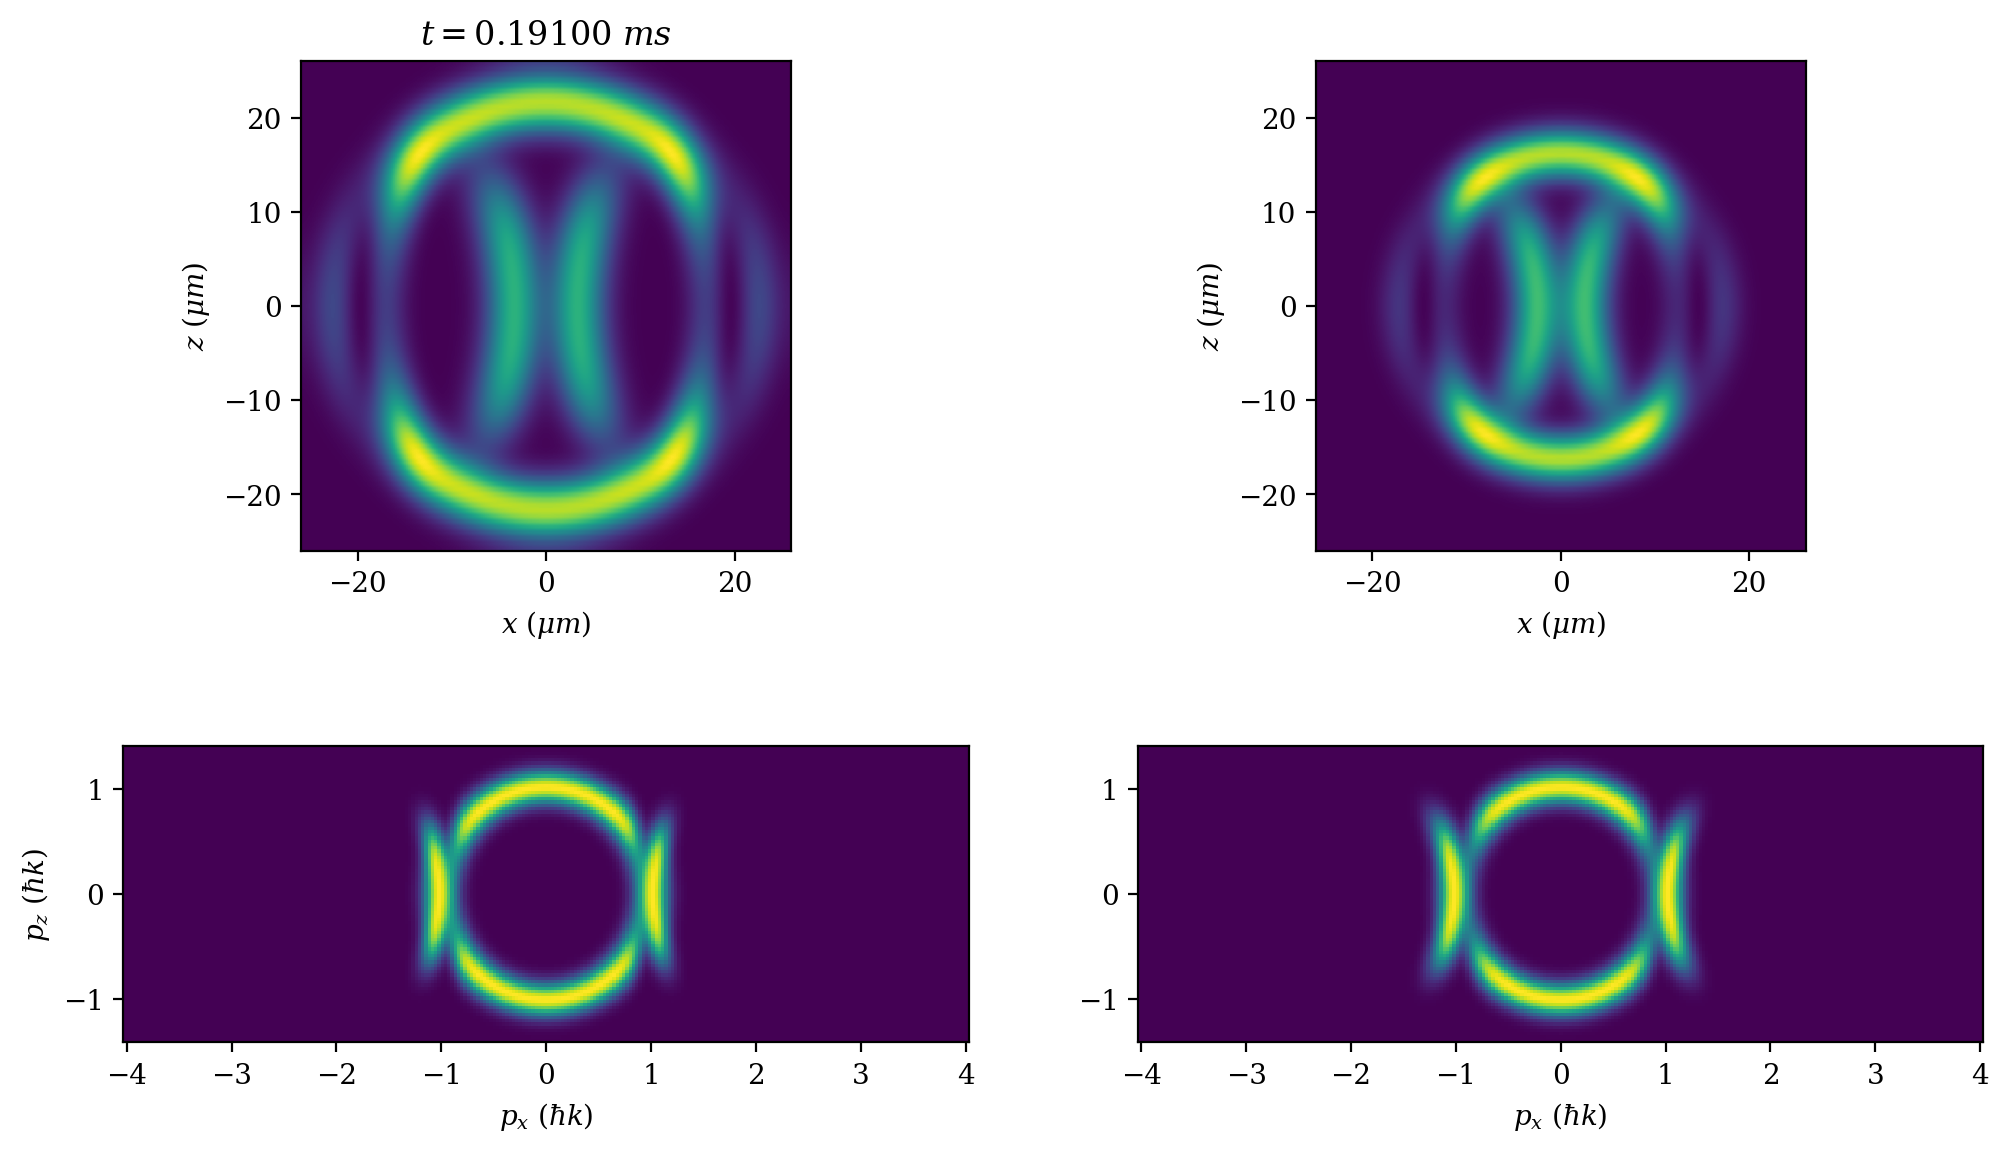

In [180]:
fb = 0
with ProgressBar(total=tMix_steps) as progressbar:
    for fb in range(tMix_frames):
        scattering_evolve_loop_plot(t,fb,psi,phi,
                                    plt_show=False, plt_save=True,plt_save_func_name="bragg_mirror")
        del phi # slower but saves memory
        gc.collect()
        for ia in prange(print_every):
            cosX3Lin = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tMirMid,tau3Pi1,0.4*V0F) * \
                                np.cos(2*k*xlin + 0*(t-tMirMid) + 0) )
            cosX4Lin = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tMirMid,tau4Pi1,0.4*V0F) * \
                                np.cos(2*k*xlin + 0*(t-tMirMid) + 0) )
            
            psi = bragg_evolve_helper_psi_step(t=t,psi_init=psi,
                                               tw3=tau3Pi2,tc3=tMirMid,
                                               tw4=tau4Pi2,tc4=tMirMid,
                                               ph3=phase0,ph4=phasePi,
                                               V3=0.4*V0F,V4=0.4*V0F,
                                               dop3=0,dop4=0
                                              )
            phi = toPhi(psi,swnf,nthreads=7)
            del psi
            phi = scattering_evolve_loop_helper2_inner_phi_step(phi)            
            psi = toPsi(phi,swnf,nthreads=7)
            psi = bragg_evolve_helper_psi_step(t=t,psi_init=psi,
                                               tw3=tau3Pi2,tc3=tMirMid,
                                               tw4=tau4Pi2,tc4=tMirMid,
                                               ph3=phase0,ph4=phasePi,
                                               V3=0.4*V0F,V4=0.4*V0F,
                                               dop3=0,dop4=0
                                              )
            t+=dt
            if progressbar != None: progressbar.update(1)
        
        gc.collect()
        
scattering_evolve_loop_plot(t,fb+1,psi,phi,
                            plt_show=True,plt_save=True,plt_save_func_name="bragg_mirror")

In [ ]:
todo rename to bragg mixing

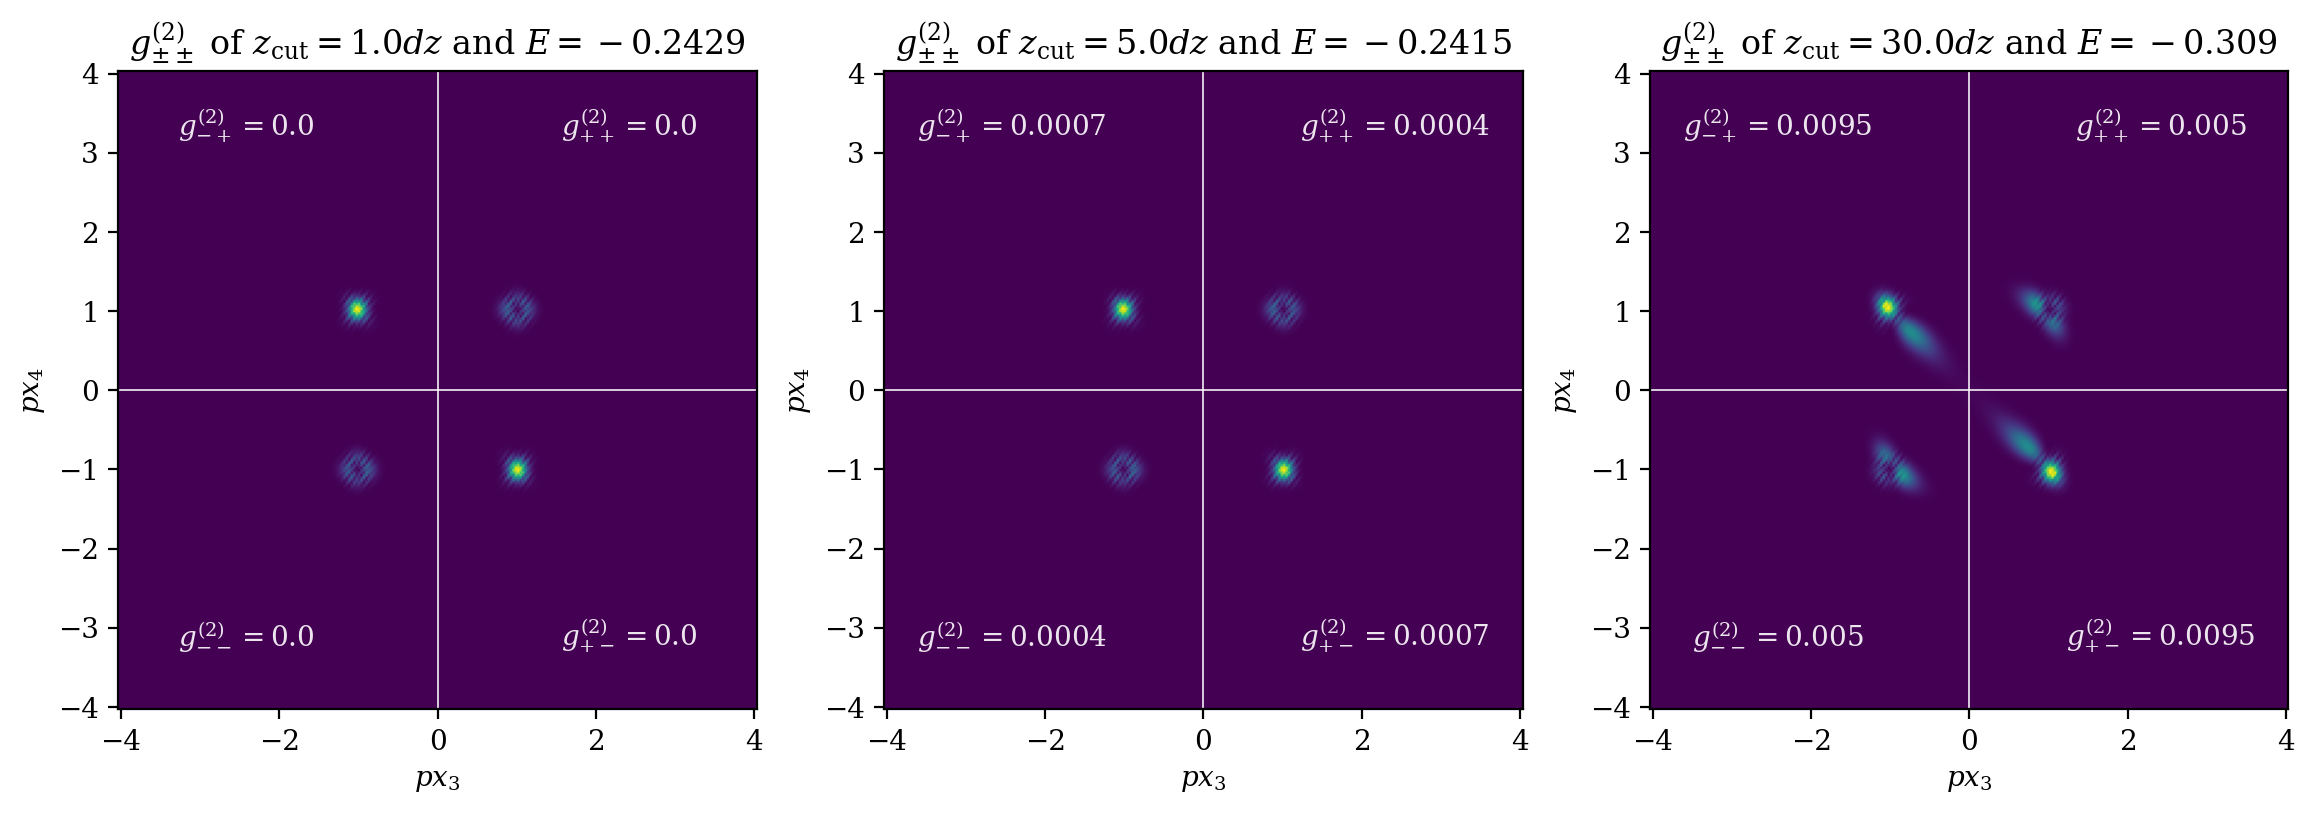

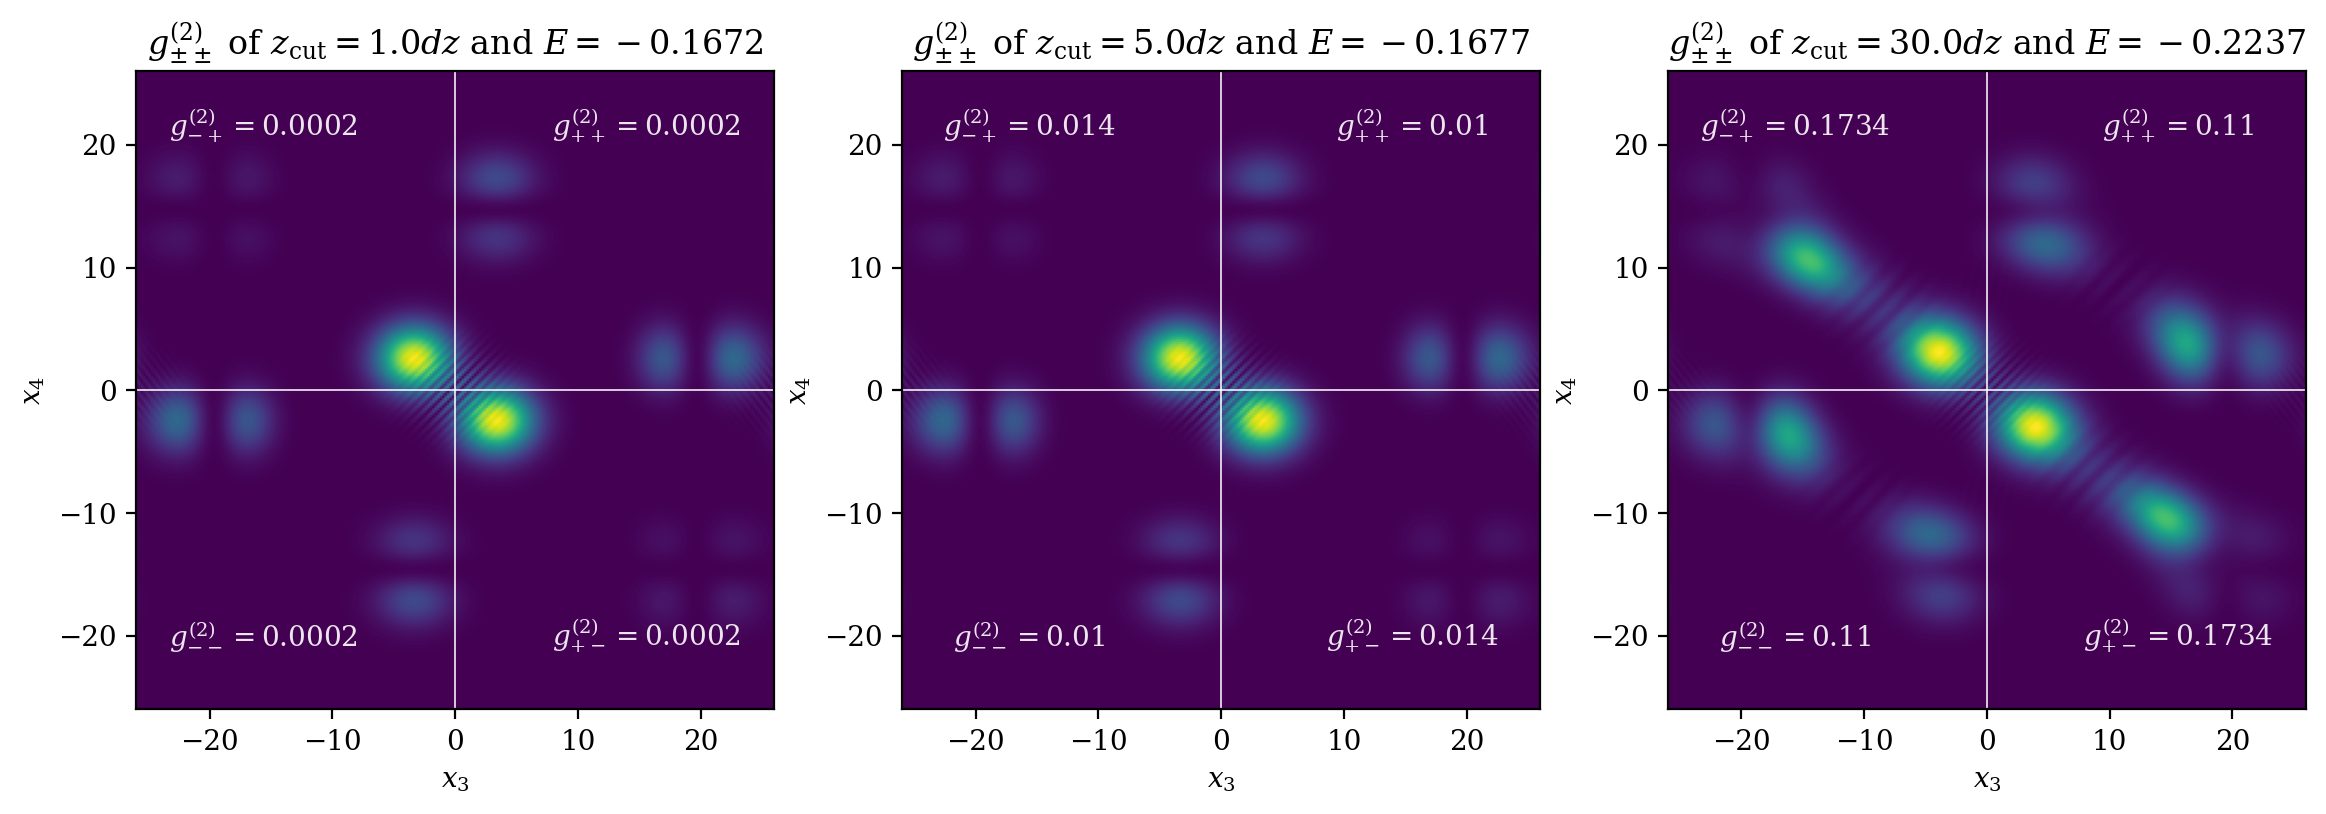

In [181]:
plt.figure(figsize=(14,6))

cut_list = [1.0, 5.0, 30.0]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(phi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4_phi(gx3x4,cut)
plt.show()
del gx3x4

plt.figure(figsize=(14,6))

cut_list = [1.0, 5.0, 30.0]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(psi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4(gx3x4,cut)
plt.show()
del gx3x4

TODO:
* phase
* bigger grid

In [75]:
plt.figure(figsize=(14,6))

cut_list = [1.0, 5.0, 30.0]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(phi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4_phi(gx3x4,cut)
plt.show()
del gx3x4

In [71]:
plt.figure(figsize=(14,6))

cut_list = [1.0, 5.0, 30.0]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(psi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4(gx3x4,cut)
plt.show()
del gx3x4

In [189]:
1/sqrt(2)

0.7071067811865475